# Estimaciones

##### Obtener los archivos de google sheet

In [66]:
%pip install python-dotenv

from dotenv import load_dotenv
import os
import pandas as pd
import urllib.parse
from IPython.display import display

load_dotenv()

sheet_ids = os.getenv("LISTA_IDS_ESTIMACIONES_GOOGLE_DRIVE")
sheet_ids = sheet_ids.split(",")

devs = os.getenv("DESARROLLADORES")
devs = devs.split(",")

print(sheet_ids)
print(devs)


Note: you may need to restart the kernel to use updated packages.
['1DN_yJoli8330FI8QEywPslfY3T4tfhSfyoVCRDhZeyk', '1ay62CqdRGoAE_VYKre7QguVpyqWe0PoqPWg-EM5bdLY', '194-mme0T0Gic4MHaHotKPO9YIn5WigBNk8qgzNQgyoU']
['Camila', 'Camilo', 'Heri']



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


##### Funciones

In [67]:
def fetch_sheets_data(sheet_ids):
    """
    Obtiene datos de múltiples hojas de Google Sheets usando sus IDs

    Args:
        sheet_ids (list): Lista de IDs de Google Sheets

    Returns:
        dict: Diccionario que contiene dataframes para cada ID de hoja
    """
    all_dataframes = {}

    for sheet_id in sheet_ids:
        sheet_name = "Hoja 1"
        # Codifica el nombre de la hoja para manejar espacios y caracteres especiales
        encoded_sheet_name = urllib.parse.quote(sheet_name)
        # Usa la variable sheet_id en lugar de codificar el ID directamente
        url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={encoded_sheet_name}"
        print(f"✅ Obteniendo datos de la hoja: {sheet_id}")

        try:
            df = pd.read_csv(url)
            all_dataframes[sheet_id] = df
            print(f"Datos cargados correctamente con {len(df)} filas\n")
        except Exception as e:
            print(f"Error al leer la hoja {sheet_id}: {e}")

    return all_dataframes


##### Procesar los datos

In [68]:
# Llamar a la función con nuestros IDs de hoja
dataframes = fetch_sheets_data(sheet_ids)

# Asignar nombres de desarrolladores a cada dataframe
df_list = []
for sheet_id, developer in zip(sheet_ids, devs):
    if sheet_id in dataframes:
        df = dataframes[sheet_id].copy()
        df["Desarrollador"] = developer  # Añadir nombre del desarrollador como columna
        df_list.append(df)

# Combinar todos los dataframes en uno solo
df_estimaciones = pd.concat(df_list, ignore_index=True)

# Eliminar las filas donde el campo Incidencia es NaN
df_estimaciones = df_estimaciones.dropna(subset=["Incidencia"])
# También eliminar las filas donde Horas totales es NaN
df_estimaciones = df_estimaciones.dropna(subset=["Horas totales"])

# Convertir la columna "Fecha inicio" al formato datetime
df_estimaciones["Fecha inicio"] = pd.to_datetime(
    df_estimaciones["Fecha inicio"], format="%d/%m/%Y", errors="coerce"
)

# Extraer el año y el mes de la fecha en formato "YYYY-MM"
df_estimaciones["Año_Mes"] = df_estimaciones["Fecha inicio"].dt.strftime("%Y-%m")

# Mostrar el dataframe combinado
print(f"\nDataFrame combinado con {len(df_estimaciones)} filas")
display(df_estimaciones)





✅ Obteniendo datos de la hoja: 1DN_yJoli8330FI8QEywPslfY3T4tfhSfyoVCRDhZeyk
Datos cargados correctamente con 131 filas

✅ Obteniendo datos de la hoja: 1ay62CqdRGoAE_VYKre7QguVpyqWe0PoqPWg-EM5bdLY
Datos cargados correctamente con 98 filas

✅ Obteniendo datos de la hoja: 194-mme0T0Gic4MHaHotKPO9YIn5WigBNk8qgzNQgyoU


Datos cargados correctamente con 120 filas


DataFrame combinado con 314 filas


,Fecha inicio,Proyecto,Incidencia,¿🎯Sprint?,Horas estimadas,Horas totales,Diferencia (horas),Notas,Desarrollador,Año_Mes
6,2025-03-12,B2B,BTB-736,False,4.0,2.0,2,NaN,Camila,2025-03
7,2025-03-11,B2B,BTB-746,False,4.0,6.0,-2,NaN,Camila,2025-03
8,2025-03-07,B2B,BTB-625,False,4.0,4.0,0,NaN,Camila,2025-03
9,2025-03-06,B2B,BTB-743,False,4.0,3.0,1,NaN,Camila,2025-03
10,2025-03-05,Profuturo,CPK-915,False,4.0,2.0,2,NaN,Camila,2025-03
...,...,...,...,...,...,...,...,...,...,...
344,2024-08-09,Profuturo,CPK-732,False,4.0,4.0,0,NaN,Heri,2024-08
345,2024-08-06,B2B,BTB-477,False,16.0,17.0,-1,Submodulo sin refactorizacion,Heri,2024-08
346,2024-08-02,B2B,BTB-466,True,8.0,18.0,-10,Codigo no tenia una buena estructura y malas p...,Heri,2024-08
347,2024-08-01,Profuturo,CPK-747,True,8.0,9.0,-1,Al modificar la tarea programada se deben real...,Heri,2024-08


##### 1. Análisis de preciosión de estimaciones de tiempo

###### Desviación

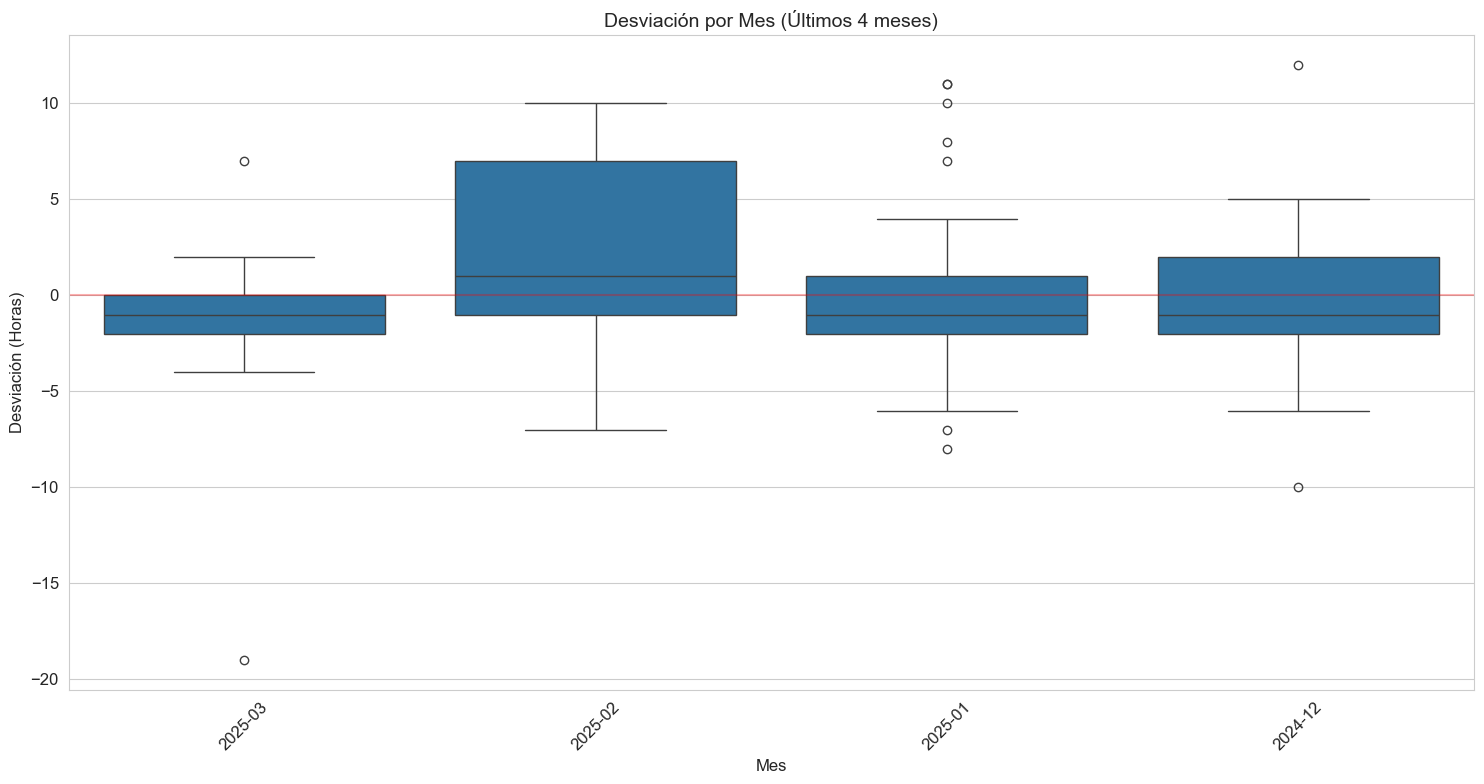


===== EXPLICACIÓN DE LOS GRÁFICOS DE BOXPLOT =====
En un diagrama de caja (boxplot):
- La línea central representa la mediana
- La caja representa el rango intercuartil (IQR): del percentil 25 al 75
- Los 'bigotes' se extienden hasta 1.5 * IQR
- Los puntos fuera de los bigotes son valores atípicos (outliers)
- Una desviación positiva significa que se tomó más tiempo del estimado
- Una desviación negativa significa que se tomó menos tiempo del estimado

Interpretación de las desviaciones:
- Desviación = 0: La estimación fue exacta
- Desviación > 0: Se subestimó (tomó más tiempo del estimado)
- Desviación < 0: Se sobreestimó (tomó menos tiempo del estimado)


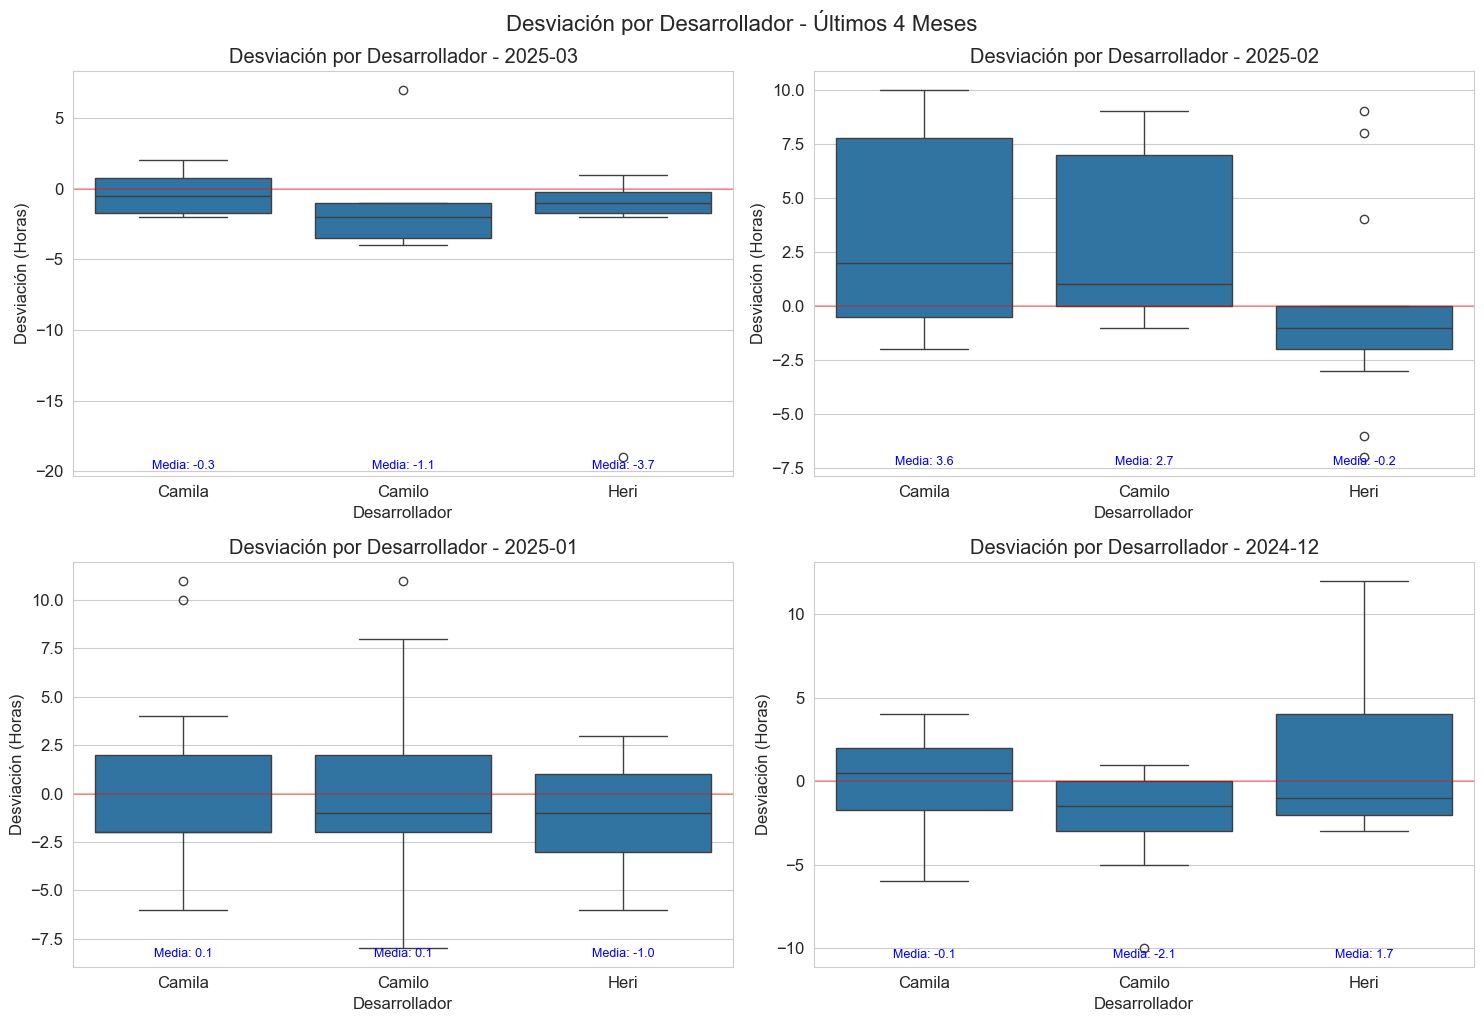

Estadísticas de desviación por desarrollador en los últimos 4 meses:

--- 2025-03 ---
Camila: Media=-0.3, Mediana=-0.5, n=6
Camilo: Media=-1.1, Mediana=-2.0, n=7
Heri: Media=-3.7, Mediana=-1.0, n=6

--- 2025-02 ---
Camila: Media=3.6, Mediana=2.0, n=14
Camilo: Media=2.7, Mediana=1.0, n=9
Heri: Media=-0.2, Mediana=-1.0, n=13

--- 2025-01 ---
Camila: Media=0.1, Mediana=-2.0, n=19
Camilo: Media=0.1, Mediana=-1.0, n=17
Heri: Media=-1.0, Mediana=-1.0, n=21

--- 2024-12 ---
Camila: Media=-0.1, Mediana=0.5, n=10
Camilo: Media=-2.1, Mediana=-1.5, n=12
Heri: Media=1.7, Mediana=-1.0, n=7


In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reporte de desviaciones por mes

# 📈 Asegurarse de que tenemos la columna Desviacion
if "Desviacion" not in df_estimaciones.columns:
    df_estimaciones["Desviacion"] = (
        df_estimaciones["Horas totales"] - df_estimaciones["Horas estimadas"]
    )

# Extraer el mes y año en un formato más legible
df_estimaciones["Mes"] = df_estimaciones["Fecha inicio"].dt.strftime("%B")
df_estimaciones["Año"] = df_estimaciones["Fecha inicio"].dt.year
df_estimaciones["Mes_Año"] = (
    df_estimaciones["Mes"] + " " + df_estimaciones["Año"].astype(str)
)

# Obtener los últimos 4 meses
fechas_unicas = df_estimaciones["Año_Mes"].sort_values(ascending=False).unique()
ultimos_meses_seleccionados = [m for m in fechas_unicas if pd.notna(m)][:4]

# Filtrar el dataframe para los últimos 4 meses
df_ultimos_meses = df_estimaciones[
    df_estimaciones["Año_Mes"].isin(ultimos_meses_seleccionados)
]

# Crear una figura para ocupar todo el espacio disponible
plt.figure(figsize=(15, 8))

# 📈 Boxplot de desviaciones por mes
sns.boxplot(
    x="Año_Mes",
    y="Desviacion",
    data=df_ultimos_meses,
    order=ultimos_meses_seleccionados,
)
plt.title("Desviación por Mes (Últimos 4 meses)", fontsize=14)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Desviación (Horas)", fontsize=12)
plt.xticks(rotation=45)
plt.axhline(y=0, color="r", linestyle="-", alpha=0.3)

# Ajustar el layout para usar todo el espacio
plt.tight_layout()
plt.show()

# -----------------------------------------


# Add an explanation of boxplots
print("\n===== EXPLICACIÓN DE LOS GRÁFICOS DE BOXPLOT =====")
print("En un diagrama de caja (boxplot):")
print("- La línea central representa la mediana")
print("- La caja representa el rango intercuartil (IQR): del percentil 25 al 75")
print("- Los 'bigotes' se extienden hasta 1.5 * IQR")
print("- Los puntos fuera de los bigotes son valores atípicos (outliers)")
print("- Una desviación positiva significa que se tomó más tiempo del estimado")
print("- Una desviación negativa significa que se tomó menos tiempo del estimado")
print("\nInterpretación de las desviaciones:")
print("- Desviación = 0: La estimación fue exacta")
print("- Desviación > 0: Se subestimó (tomó más tiempo del estimado)")
print("- Desviación < 0: Se sobreestimó (tomó menos tiempo del estimado)")


# -----------------------------------------


# 📈 Crear una figura para las 4 gráficas (una por mes)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()


# Ordenar los últimos 4 meses para procesarlos en orden cronológico
meses_ordenados = sorted(ultimos_meses_seleccionados, reverse=True)

# Para cada mes, crear un gráfico de desviación por desarrollador
for i, mes in enumerate(meses_ordenados):
    # Filtrar datos para el mes actual
    df_mes = df_ultimos_meses[df_ultimos_meses["Año_Mes"] == mes]

    # Crear boxplot para cada desarrollador en este mes
    sns.boxplot(x="Desarrollador", y="Desviacion", data=df_mes, ax=axes[i])

    # Añadir línea horizontal en y=0 para referencia
    axes[i].axhline(y=0, color="r", linestyle="-", alpha=0.3)

    # Configurar etiquetas y título
    axes[i].set_title(f"Desviación por Desarrollador - {mes}")
    axes[i].set_ylabel("Desviación (Horas)")
    axes[i].set_xlabel("Desarrollador")

    # Añadir etiquetas con valores medios
    stats = df_mes.groupby("Desarrollador")["Desviacion"].mean()
    for j, dev in enumerate(axes[i].get_xticklabels()):
        dev_name = dev.get_text()
        if dev_name in stats.index:
            axes[i].text(
                j,
                axes[i].get_ylim()[0] + 0.5,
                f"Media: {stats[dev_name]:.1f}",
                ha="center",
                fontsize=9,
                color="blue",
            )

plt.tight_layout()
plt.suptitle("Desviación por Desarrollador - Últimos 4 Meses", y=1.02, fontsize=16)
plt.show()

# Imprimir estadísticas complementarias
print("Estadísticas de desviación por desarrollador en los últimos 4 meses:")
for mes in meses_ordenados:
    stats = (
        df_ultimos_meses[df_ultimos_meses["Año_Mes"] == mes]
        .groupby("Desarrollador")["Desviacion"]
        .agg(["mean", "median", "std", "count"])
    )
    print(f"\n--- {mes} ---")
    for dev in stats.index:
        print(
            f"{dev}: Media={stats.loc[dev, 'mean']:.1f}, Mediana={stats.loc[dev, 'median']:.1f}, n={int(stats.loc[dev, 'count'])}"
        )


C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_38268\2817891578.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimos_meses["Precisión"] = (
C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_38268\2817891578.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimos_meses["Precisión"] = df_ultimos_meses["Precisión"].clip(0, 100)


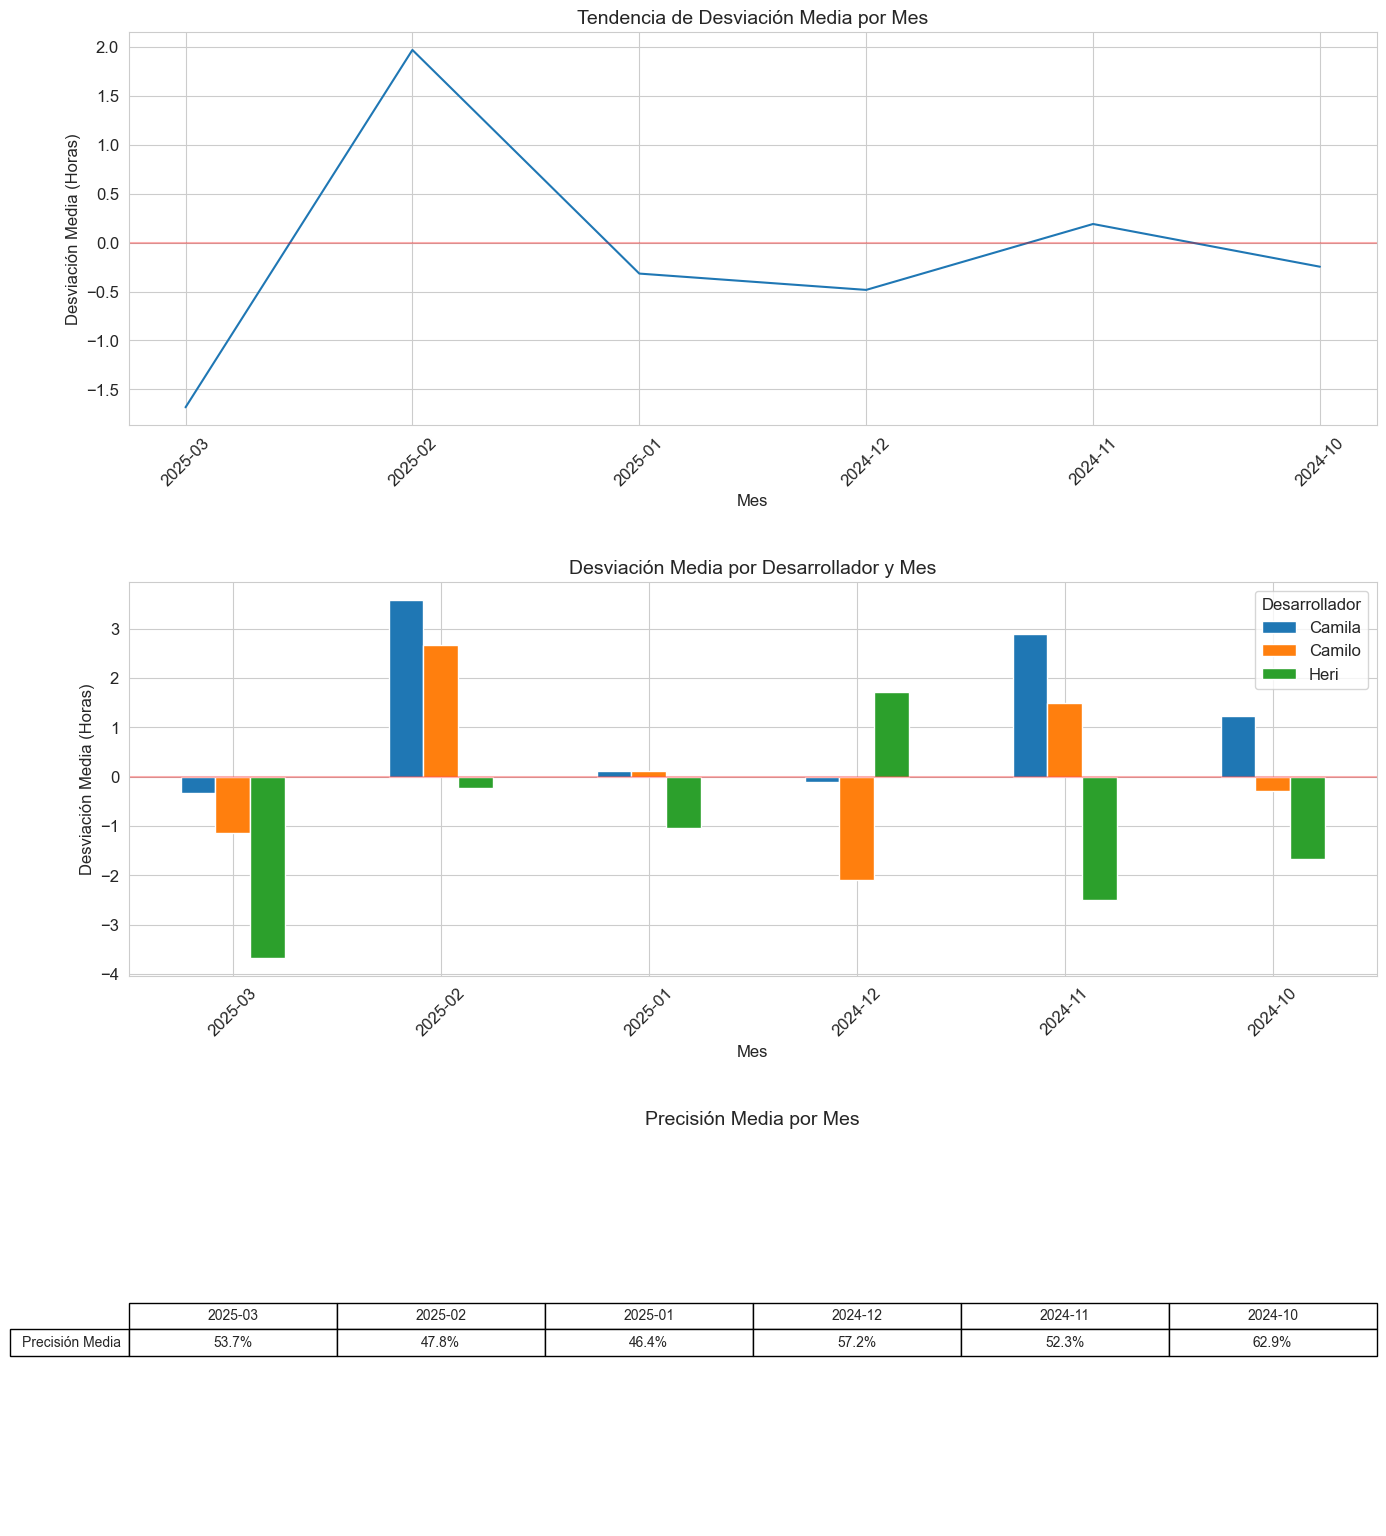

Estadísticas de desviación por mes:

--- 2025-03 ---
Camila: Media=-0.3, Mediana=-0.5, n=6
Camilo: Media=-1.1, Mediana=-2.0, n=7
Heri: Media=-3.7, Mediana=-1.0, n=6

--- 2025-02 ---
Camila: Media=3.6, Mediana=2.0, n=14
Camilo: Media=2.7, Mediana=1.0, n=9
Heri: Media=-0.2, Mediana=-1.0, n=13

--- 2025-01 ---
Camila: Media=0.1, Mediana=-2.0, n=19
Camilo: Media=0.1, Mediana=-1.0, n=17
Heri: Media=-1.0, Mediana=-1.0, n=21

--- 2024-12 ---
Camila: Media=-0.1, Mediana=0.5, n=10
Camilo: Media=-2.1, Mediana=-1.5, n=12
Heri: Media=1.7, Mediana=-1.0, n=7

--- 2024-11 ---
Camila: Media=2.9, Mediana=1.0, n=19
Camilo: Media=1.5, Mediana=0.5, n=6
Heri: Media=-2.5, Mediana=-1.0, n=22

--- 2024-10 ---
Camila: Media=1.2, Mediana=0.0, n=18
Camilo: Media=-0.3, Mediana=0.0, n=21
Heri: Media=-1.7, Mediana=-0.5, n=18


In [70]:
cantidad_meses_requeridos = 6

# Obtener los últimos meses
fechas_unicas = df_estimaciones["Año_Mes"].sort_values(ascending=False).unique()
ultimos_meses_seleccionados = [m for m in fechas_unicas if pd.notna(m)][
    :cantidad_meses_requeridos
]

# Filtrar el dataframe para los meses seleccionados
df_ultimos_meses = df_estimaciones[
    df_estimaciones["Año_Mes"].isin(ultimos_meses_seleccionados)
]


plt.figure(figsize=(15, 22))  # Increased height for better spacing

# 📈 2. Línea de tendencia de la desviación media por mes
plt.subplot(4, 1, 1)  # 4 rows, 1 column, 1st plot
promedio_desviacion_mes = (
    df_ultimos_meses.groupby("Año_Mes")["Desviacion"]
    .mean()
    .reindex(ultimos_meses_seleccionados)
)
sns.lineplot(x=promedio_desviacion_mes.index, y=promedio_desviacion_mes.values)
plt.title("Tendencia de Desviación Media por Mes", fontsize=14)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Desviación Media (Horas)", fontsize=12)
plt.xticks(rotation=45)
plt.axhline(y=0, color="r", linestyle="-", alpha=0.3)

# 📈 3. Gráfico de barras apiladas de desviación por desarrollador y mes
plt.subplot(4, 1, 2)  # 4 rows, 1 column, 2nd plot
pivot_data = df_ultimos_meses.pivot_table(
    index="Año_Mes", columns="Desarrollador", values="Desviacion", aggfunc="mean"
).reindex(ultimos_meses_seleccionados)
pivot_data.plot(kind="bar", ax=plt.gca())
plt.title("Desviación Media por Desarrollador y Mes", fontsize=14)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Desviación Media (Horas)", fontsize=12)
plt.xticks(rotation=45)
plt.axhline(y=0, color="r", linestyle="-", alpha=0.3)
plt.legend(title="Desarrollador")

# 📈 4. Tabla de precisión por mes
plt.subplot(4, 1, 3)  # 4 rows, 1 column, 3rd plot
# Calcular la precisión como (1 - |desviación| / horas estimadas) * 100
df_ultimos_meses["Precisión"] = (
    1 - abs(df_ultimos_meses["Desviacion"]) / df_ultimos_meses["Horas estimadas"]
) * 100
# Limitar la precisión a un rango de 0-100% (evitar valores negativos)
df_ultimos_meses["Precisión"] = df_ultimos_meses["Precisión"].clip(0, 100)

precision_mensual = (
    df_ultimos_meses.groupby("Año_Mes")["Precisión"]
    .mean()
    .reindex(ultimos_meses_seleccionados)
)

# Crear una tabla con la precisión
plt.axis("off")
tabla = plt.table(
    cellText=[[f"{v:.1f}%" for v in precision_mensual.values]],
    rowLabels=["Precisión Media"],
    colLabels=precision_mensual.index,
    loc="center",
    cellLoc="center",
)
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 1.5)
plt.title("Precisión Media por Mes", fontsize=14)

# Ajustar el espacio entre subplots
plt.tight_layout(pad=4.0)  # Aumentar el padding entre subplots
plt.subplots_adjust(hspace=0.4)  # Aumentar el espacio horizontal entre subplots

plt.show()

# Imprimir estadísticas mensuales
print("Estadísticas de desviación por mes:")
for mes in ultimos_meses_seleccionados:
    stats = (
        df_ultimos_meses[df_ultimos_meses["Año_Mes"] == mes]
        .groupby("Desarrollador")["Desviacion"]
        .agg(["mean", "median", "std", "count"])
    )
    print(f"\n--- {mes} ---")
    for dev in stats.index:
        stat = stats.loc[dev]
        print(
            f"{dev}: Media={stat['mean']:.1f}, Mediana={stat['median']:.1f}, n={int(stat['count'])}"
        )

###### Horas estimadas vs reales

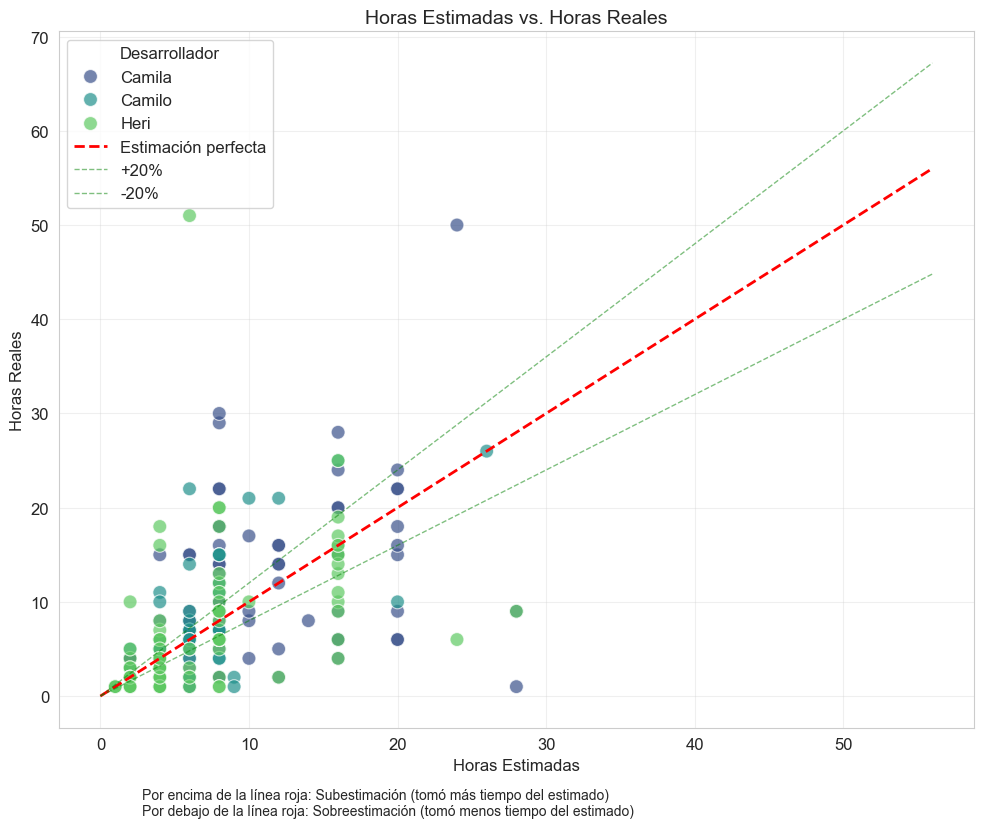


Precisión de estimación por desarrollador:
  Desarrollador  Precisión (%)
0        Camila      11.779157
1        Camilo      -6.182950
2          Heri      -0.049148

Desviación promedio por Proyecto (%):
Proyecto
API Data ERP     -77.777778
API Documentos   -41.666667
B2B               -3.516757
Profuturo         12.920082
API Empleados     15.722222
Name: Porcentaje Desviacion, dtype: float64

Resumen de desviaciones por desarrollador (en horas):
               Media  Mediana  DesvEstándar  Total
Desarrollador                                     
Camila          0.35      0.0          6.89    118
Camilo          0.08     -1.0          3.96     87
Heri           -0.39     -1.0          6.46    109


In [71]:
# 📈 Gráfico de dispersión de horas estimadas vs. horas totales con mejoras
plt.figure(figsize=(10, 8))

# Crear el scatter plot con un tamaño de punto más visible y transparencia
scatter = sns.scatterplot(
    x="Horas estimadas",
    y="Horas totales",
    hue="Desarrollador",
    data=df_estimaciones,
    alpha=0.7,
    s=100,  # Tamaño de punto más grande
    palette="viridis",
)

# Añadir una línea diagonal que representa estimaciones perfectas
max_val = (
    max(
        df_estimaciones["Horas estimadas"].max(), df_estimaciones["Horas totales"].max()
    )
    + 5
)
plt.plot([0, max_val], [0, max_val], "r--", label="Estimación perfecta", linewidth=2)

# Añadir líneas de guía para visualizar subestimaciones y sobreestimaciones (±20%)
plt.plot([0, max_val], [0, max_val * 1.2], "g--", alpha=0.5, linewidth=1, label="+20%")
plt.plot([0, max_val], [0, max_val * 0.8], "g--", alpha=0.5, linewidth=1, label="-20%")

# Añadir etiquetas y título
plt.title("Horas Estimadas vs. Horas Reales", fontsize=14)
plt.xlabel("Horas Estimadas", fontsize=12)
plt.ylabel("Horas Reales", fontsize=12)
plt.grid(True, alpha=0.3)

# Ajustar leyenda
plt.legend(title="Desarrollador", loc="upper left")

# Texto explicativo
plt.figtext(
    0.15,
    -0.03,
    "Por encima de la línea roja: Subestimación (tomó más tiempo del estimado)\nPor debajo de la línea roja: Sobreestimación (tomó menos tiempo del estimado)",
    ha="left",
    fontsize=10,
    bbox={"facecolor": "white", "alpha": 0.8, "pad": 5},
)

plt.tight_layout()
plt.show()

# Calcular estadísticas de precisión de estimación
df_estimaciones["Porcentaje Desviacion"] = (
    df_estimaciones["Desviacion"] / df_estimaciones["Horas estimadas"]
) * 100

# Promedio de desviación por desarrollador
precision_por_dev = (
    df_estimaciones.groupby("Desarrollador")["Porcentaje Desviacion"]
    .mean()
    .reset_index()
)
precision_por_dev.columns = ["Desarrollador", "Precisión (%)"]

# Mostrar tabla de precisión por desarrollador
print("\nPrecisión de estimación por desarrollador:")
print(precision_por_dev)

# Promedio de desviación por proyecto
promedio_desviacion_proyecto = (
    df_estimaciones.groupby("Proyecto")["Porcentaje Desviacion"].mean().sort_values()
)
print("\nDesviación promedio por Proyecto (%):")
print(promedio_desviacion_proyecto)

# Estadísticas resumen por desarrollador
resumen_por_dev = (
    df_estimaciones.groupby("Desarrollador")["Desviacion"]
    .agg(Media="mean", Mediana="median", DesvEstándar="std", Total="count")
    .round(2)
)

print("\nResumen de desviaciones por desarrollador (en horas):")
print(resumen_por_dev)

##### 2. Ranking de desarrolladores según precisión en estimaciones

C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_38268\2992329888.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_38268\2992329888.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


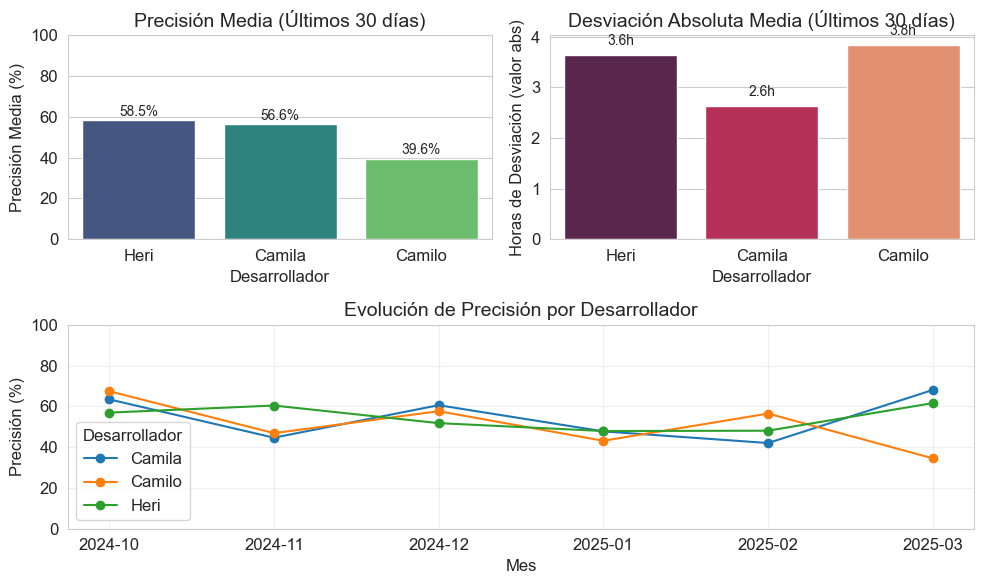


=== RANKING DE DESARROLLADORES POR PRECISIÓN ===
Desarrollador  Precisión_Media  Desviación_Absoluta  Total_Tareas
         Heri            58.55                 3.64            14
       Camila            56.56                 2.62            16
       Camilo            39.58                 3.83            12

=== TENDENCIA A SUBESTIMAR O SOBREESTIMAR ===
Desarrollador  Subestimaciones (%)  Precisas (%)  Sobreestimaciones (%)  Tareas_Totales
         Heri                 25.7          14.7                   59.6           109.0
       Camilo                 32.2          12.6                   55.2            87.0
       Camila                 46.6          10.2                   43.2           118.0


C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_38268\2992329888.py:92: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [72]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Verificar si df_estimaciones ya tiene la columna Precisión, si no, la calculamos
if "Precisión" not in df_estimaciones.columns:
    # Calculamos la precisión como un porcentaje basado en la desviación relativa
    df_estimaciones["Precisión"] = 100 - (
        abs(df_estimaciones["Porcentaje Desviacion"]).clip(upper=100)
    )

# Filtrar datos de los últimos 30 días
hoy = datetime.now()
fecha_limite = hoy - timedelta(days=30)
df_ultimo_mes = df_estimaciones[df_estimaciones["Fecha inicio"] >= fecha_limite]

# 1. Calcular métricas clave de precisión por desarrollador para los últimos 30 días
metricas_ultimo_mes = (
    df_ultimo_mes.groupby("Desarrollador")
    .agg(
        Desviación_Media=("Desviacion", "mean"),
        Desviación_Mediana=("Desviacion", "median"),
        Desviación_Absoluta=("Desviacion", lambda x: np.mean(np.abs(x))),
        Precisión_Media=("Precisión", "mean"),
        Total_Tareas=("Incidencia", "count"),
    )
    .reset_index()
)

# Ordenar por precisión media (mayor a menor)
metricas_ultimo_mes = metricas_ultimo_mes.sort_values(
    "Precisión_Media", ascending=False
)

# 2. Crear un gráfico de barras para la precisión media
plt.figure(figsize=(14, 10))

# Gráfico 1: Precisión media (últimos 30 días)
plt.subplot(2, 2, 1)
sns.barplot(
    x="Desarrollador", y="Precisión_Media", data=metricas_ultimo_mes, palette="viridis"
)
plt.title("Precisión Media (Últimos 30 días)", fontsize=14)
plt.xlabel("Desarrollador", fontsize=12)
plt.ylabel("Precisión Media (%)", fontsize=12)
plt.ylim(0, 100)  # Limitar la precisión entre 0% y 100%

# Añadir etiquetas de valores
for i, v in enumerate(metricas_ultimo_mes["Precisión_Media"]):
    plt.text(i, v + 2, f"{v:.1f}%", ha="center", fontsize=10)

# Gráfico 2: Desviación absoluta media (últimos 30 días)
plt.subplot(2, 2, 2)
sns.barplot(
    x="Desarrollador",
    y="Desviación_Absoluta",
    data=metricas_ultimo_mes,
    palette="rocket",
)
plt.title("Desviación Absoluta Media (Últimos 30 días)", fontsize=14)
plt.xlabel("Desarrollador", fontsize=12)
plt.ylabel("Horas de Desviación (valor abs)", fontsize=12)

# Añadir etiquetas de valores
for i, v in enumerate(metricas_ultimo_mes["Desviación_Absoluta"]):
    plt.text(i, v + 0.2, f"{v:.1f}h", ha="center", fontsize=10)

# Gráfico 3: Tendencia temporal de precisión por desarrollador
plt.subplot(2, 1, 2)
# Calcular precisión media por mes y desarrollador
precision_temporal = df_ultimos_meses.pivot_table(
    index="Año_Mes", columns="Desarrollador", values="Precisión", aggfunc="mean"
).fillna(0)

# Mostrar la evolución temporal
precision_temporal.plot(kind="line", marker="o", figsize=(10, 6), ax=plt.gca())
plt.title("Evolución de Precisión por Desarrollador", fontsize=14)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Precisión (%)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# 3. Análisis adicional: Tendencia a subestimar o sobreestimar
analisis_tendencia = (
    df_estimaciones.groupby("Desarrollador")
    .apply(
        lambda x: pd.Series(
            {
                "Subestimaciones (%)": 100 * (x["Desviacion"] > 0).mean(),
                "Precisas (%)": 100 * (x["Desviacion"] == 0).mean(),
                "Sobreestimaciones (%)": 100 * (x["Desviacion"] < 0).mean(),
                "Tareas_Totales": len(x),
            }
        )
    )
    .reset_index()
)

# Mostrar tabla de análisis de tendencia
print("\n=== RANKING DE DESARROLLADORES POR PRECISIÓN ===")
print(
    metricas_ultimo_mes[
        ["Desarrollador", "Precisión_Media", "Desviación_Absoluta", "Total_Tareas"]
    ]
    .sort_values("Precisión_Media", ascending=False)
    .to_string(index=False, float_format=lambda x: f"{x:.2f}")
)

print("\n=== TENDENCIA A SUBESTIMAR O SOBREESTIMAR ===")
print(
    analisis_tendencia.sort_values("Precisas (%)", ascending=False).to_string(
        index=False, float_format=lambda x: f"{x:.1f}"
    )
)

##### 3. Productividad del Equipo por Sprint o Proyecto

###### Función = generar_reporte_productividad

In [ ]:
import pandas as pd

# import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import calendar
import matplotlib.pyplot as plt


def generar_reporte_productividad(fecha_mes=None):
    """
    Genera un reporte completo de productividad para un mes específico.

    Args:
        fecha_mes: String en formato 'YYYY-MM' para especificar el mes.
                   Si es None, usa el último mes completo.

    Returns:
        fig: La figura generada con el reporte completo
    """

    # Set visualization style
    sns.set_style("whitegrid")
    plt.rcParams["figure.figsize"] = (14, 10)
    plt.rcParams["font.size"] = 12

    # Get the month data based on input or default to last month
    if fecha_mes is None:
        today = datetime.now()
        first_day_last_month = (today.replace(day=1) - timedelta(days=1)).replace(day=1)
        last_day_last_month = today.replace(day=1) - timedelta(days=1)
        year = first_day_last_month.year
        month = first_day_last_month.month
    else:
        year, month = map(int, fecha_mes.split("-"))
        first_day_last_month = datetime(year, month, 1)
        # Get last day of the specified month
        if month == 12:
            last_day_last_month = datetime(year + 1, 1, 1) - timedelta(days=1)
        else:
            last_day_last_month = datetime(year, month + 1, 1) - timedelta(days=1)

    # Filter data for the selected month
    df_mes = df_estimaciones[
        (df_estimaciones["Fecha inicio"] >= first_day_last_month)
        & (df_estimaciones["Fecha inicio"] <= last_day_last_month)
    ].copy()

    # Create a title with the month name for the report
    month_name = calendar.month_name[first_day_last_month.month]
    report_title = f"Reporte de Productividad: {month_name} {year}"

    # Create the main figure for the report
    fig = plt.figure(figsize=(16, 20))
    fig.suptitle(report_title, fontsize=24, y=0.95)
    gs = fig.add_gridspec(5, 2, height_ratios=[1, 1, 1, 1.5, 1])

    # 1. Total hours worked in the month
    total_hours = df_mes["Horas totales"].sum()
    total_tasks = len(df_mes)
    avg_hours_per_task = total_hours / total_tasks if total_tasks > 0 else 0

    # 2. Distribution of workload (hours per task)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(df_mes["Horas totales"], kde=True, ax=ax1)
    ax1.set_title("Distribución de Horas Trabajadas por Tarea")
    ax1.set_xlabel("Horas por Tarea")
    ax1.set_ylabel("Frecuencia")

    # Boxplot of hours worked per task
    ax2 = fig.add_subplot(gs[0, 1])
    sns.boxplot(x="Desarrollador", y="Horas totales", data=df_mes, ax=ax2)
    ax2.set_title("Distribución de Horas por Desarrollador")
    ax2.set_xlabel("Desarrollador")
    ax2.set_ylabel("Horas por Tarea")

    # 3. Workload comparison between developers
    hours_by_dev = df_mes.groupby("Desarrollador")["Horas totales"].agg(
        ["sum", "mean", "median", "count"]
    )
    hours_by_dev = hours_by_dev.rename(
        columns={
            "sum": "Total Horas",
            "mean": "Media por Tarea",
            "median": "Mediana por Tarea",
            "count": "Número de Tareas",
        }
    )

    # Bar chart of total hours by developer
    ax3 = fig.add_subplot(gs[1, 0])
    sns.barplot(x=hours_by_dev.index, y=hours_by_dev["Total Horas"], ax=ax3)
    ax3.set_title("Horas Totales Trabajadas por Desarrollador")
    ax3.set_xlabel("Desarrollador")
    ax3.set_ylabel("Horas Totales")

    # Number of tasks by developer
    ax4 = fig.add_subplot(gs[1, 1])
    sns.barplot(x=hours_by_dev.index, y=hours_by_dev["Número de Tareas"], ax=ax4)
    ax4.set_title("Número de Tareas por Desarrollador")
    ax4.set_xlabel("Desarrollador")
    ax4.set_ylabel("Número de Tareas")

    # 4. Significant deviations in estimations
    df_mes["Desviación (%)"] = (
        (df_mes["Horas totales"] - df_mes["Horas estimadas"])
        / df_mes["Horas estimadas"]
        * 100
    )
    df_mes["Desviación Significativa"] = (
        abs(df_mes["Desviación (%)"]) > 50
    )  # Mark deviations over 50%

    # Deviation boxplot
    ax5 = fig.add_subplot(gs[2, 0])
    sns.boxplot(x="Desarrollador", y="Desviacion", data=df_mes, ax=ax5)
    ax5.axhline(y=0, color="r", linestyle="-", alpha=0.3)
    ax5.set_title("Desviación entre Estimación y Tiempo Real")
    ax5.set_xlabel("Desarrollador")
    ax5.set_ylabel("Desviación (Horas)")

    # Distribution of deviations
    ax6 = fig.add_subplot(gs[2, 1])
    sns.histplot(df_mes["Desviación (%)"].clip(-200, 200), kde=True, ax=ax6)
    ax6.axvline(x=0, color="r", linestyle="-", alpha=0.3)
    ax6.set_title("Distribución de Desviaciones (%)")
    ax6.set_xlabel("Desviación (%)")
    ax6.set_ylabel("Frecuencia")

    # 5. Top projects with highest time demand
    hours_by_project = (
        df_mes.groupby("Proyecto")["Horas totales"].sum().sort_values(ascending=False)
    )
    tasks_by_project = df_mes.groupby("Proyecto").size()

    # Table for top projects
    ax7 = fig.add_subplot(gs[3, :])
    ax7.axis("off")
    table_data = []
    header = ["Proyecto", "Horas Totales", "Número de Tareas", "Promedio Horas/Tarea"]

    for project in hours_by_project.index[:10]:  # Top 10 projects
        avg_hours = (
            hours_by_project[project] / tasks_by_project[project]
            if tasks_by_project[project] > 0
            else 0
        )
        table_data.append(
            [
                project,
                f"{hours_by_project[project]:.1f}",
                f"{tasks_by_project[project]}",
                f"{avg_hours:.1f}",
            ]
        )

    table = ax7.table(
        cellText=table_data, colLabels=header, loc="center", cellLoc="center"
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    ax7.set_title("Top Proyectos por Demanda de Tiempo", fontsize=14, pad=20)

    # Tasks with significant deviations
    significant_deviations = df_mes[df_mes["Desviación Significativa"]].sort_values(
        by="Desviación (%)", ascending=False
    )
    significant_deviations = significant_deviations[
        [
            "Incidencia",
            "Desarrollador",
            "Proyecto",
            "Horas estimadas",
            "Horas totales",
            "Desviación (%)",
        ]
    ]

    # Table for significant deviations
    ax8 = fig.add_subplot(gs[4, :])
    ax8.axis("off")
    if len(significant_deviations) > 0:
        dev_table_data = []
        dev_header = [
            "Incidencia",
            "Desarrollador",
            "Proyecto",
            "H. Est.",
            "H. Real",
            "Desv. (%)",
        ]

        for _, row in significant_deviations.head(8).iterrows():  # Top 8 deviations
            dev_table_data.append(
                [
                    row["Incidencia"],
                    row["Desarrollador"],
                    row["Proyecto"],
                    f"{row['Horas estimadas']:.1f}",
                    f"{row['Horas totales']:.1f}",
                    f"{row['Desviación (%)']:.1f}%",
                ]
            )

        dev_table = ax8.table(
            cellText=dev_table_data,
            colLabels=dev_header,
            loc="center",
            cellLoc="center",
        )
        dev_table.auto_set_font_size(False)
        dev_table.set_fontsize(12)
        dev_table.scale(1, 1.5)
        ax8.set_title(
            "Tareas con Desviaciones Significativas (>50%)", fontsize=14, pad=20
        )
    else:
        ax8.text(
            0.5,
            0.5,
            "No se encontraron desviaciones significativas",
            ha="center",
            fontsize=14,
        )

    # Summary statistics
    summary_text = f"""
    RESUMEN DEL MES: {month_name} {year}
    ---------------------------------
    • Total de horas trabajadas: {total_hours:.1f}
    • Número total de tareas: {total_tasks}
    • Promedio de horas por tarea: {avg_hours_per_task:.1f}
    • Desarrollador con mayor carga: {hours_by_dev["Total Horas"].idxmax()} ({hours_by_dev["Total Horas"].max():.1f} horas)
    • Desarrollador con menor carga: {hours_by_dev["Total Horas"].idxmin()} ({hours_by_dev["Total Horas"].min():.1f} horas)
    • Proyecto con mayor demanda: {hours_by_project.index[0]} ({hours_by_project.iloc[0]:.1f} horas)
    """

    plt.figtext(
        0.5,
        0.02,
        summary_text,
        ha="center",
        fontsize=14,
        bbox={"facecolor": "#f0f0f0", "alpha": 0.5, "pad": 10},
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.93])

    # Return additional useful information
    report_data = {
        "total_hours": total_hours,
        "total_tasks": total_tasks,
        "avg_hours_per_task": avg_hours_per_task,
        "hours_by_dev": hours_by_dev,
        "hours_by_project": hours_by_project,
        "tasks_by_project": tasks_by_project,
        "significant_deviations": significant_deviations,
        "summary_text": summary_text,
        "report_title": report_title,
        "month_name": month_name,
        "year": year,
    }

    return fig, report_data

###### Imprimir reportes Productividad

Generando reporte para el mes: 2025-03


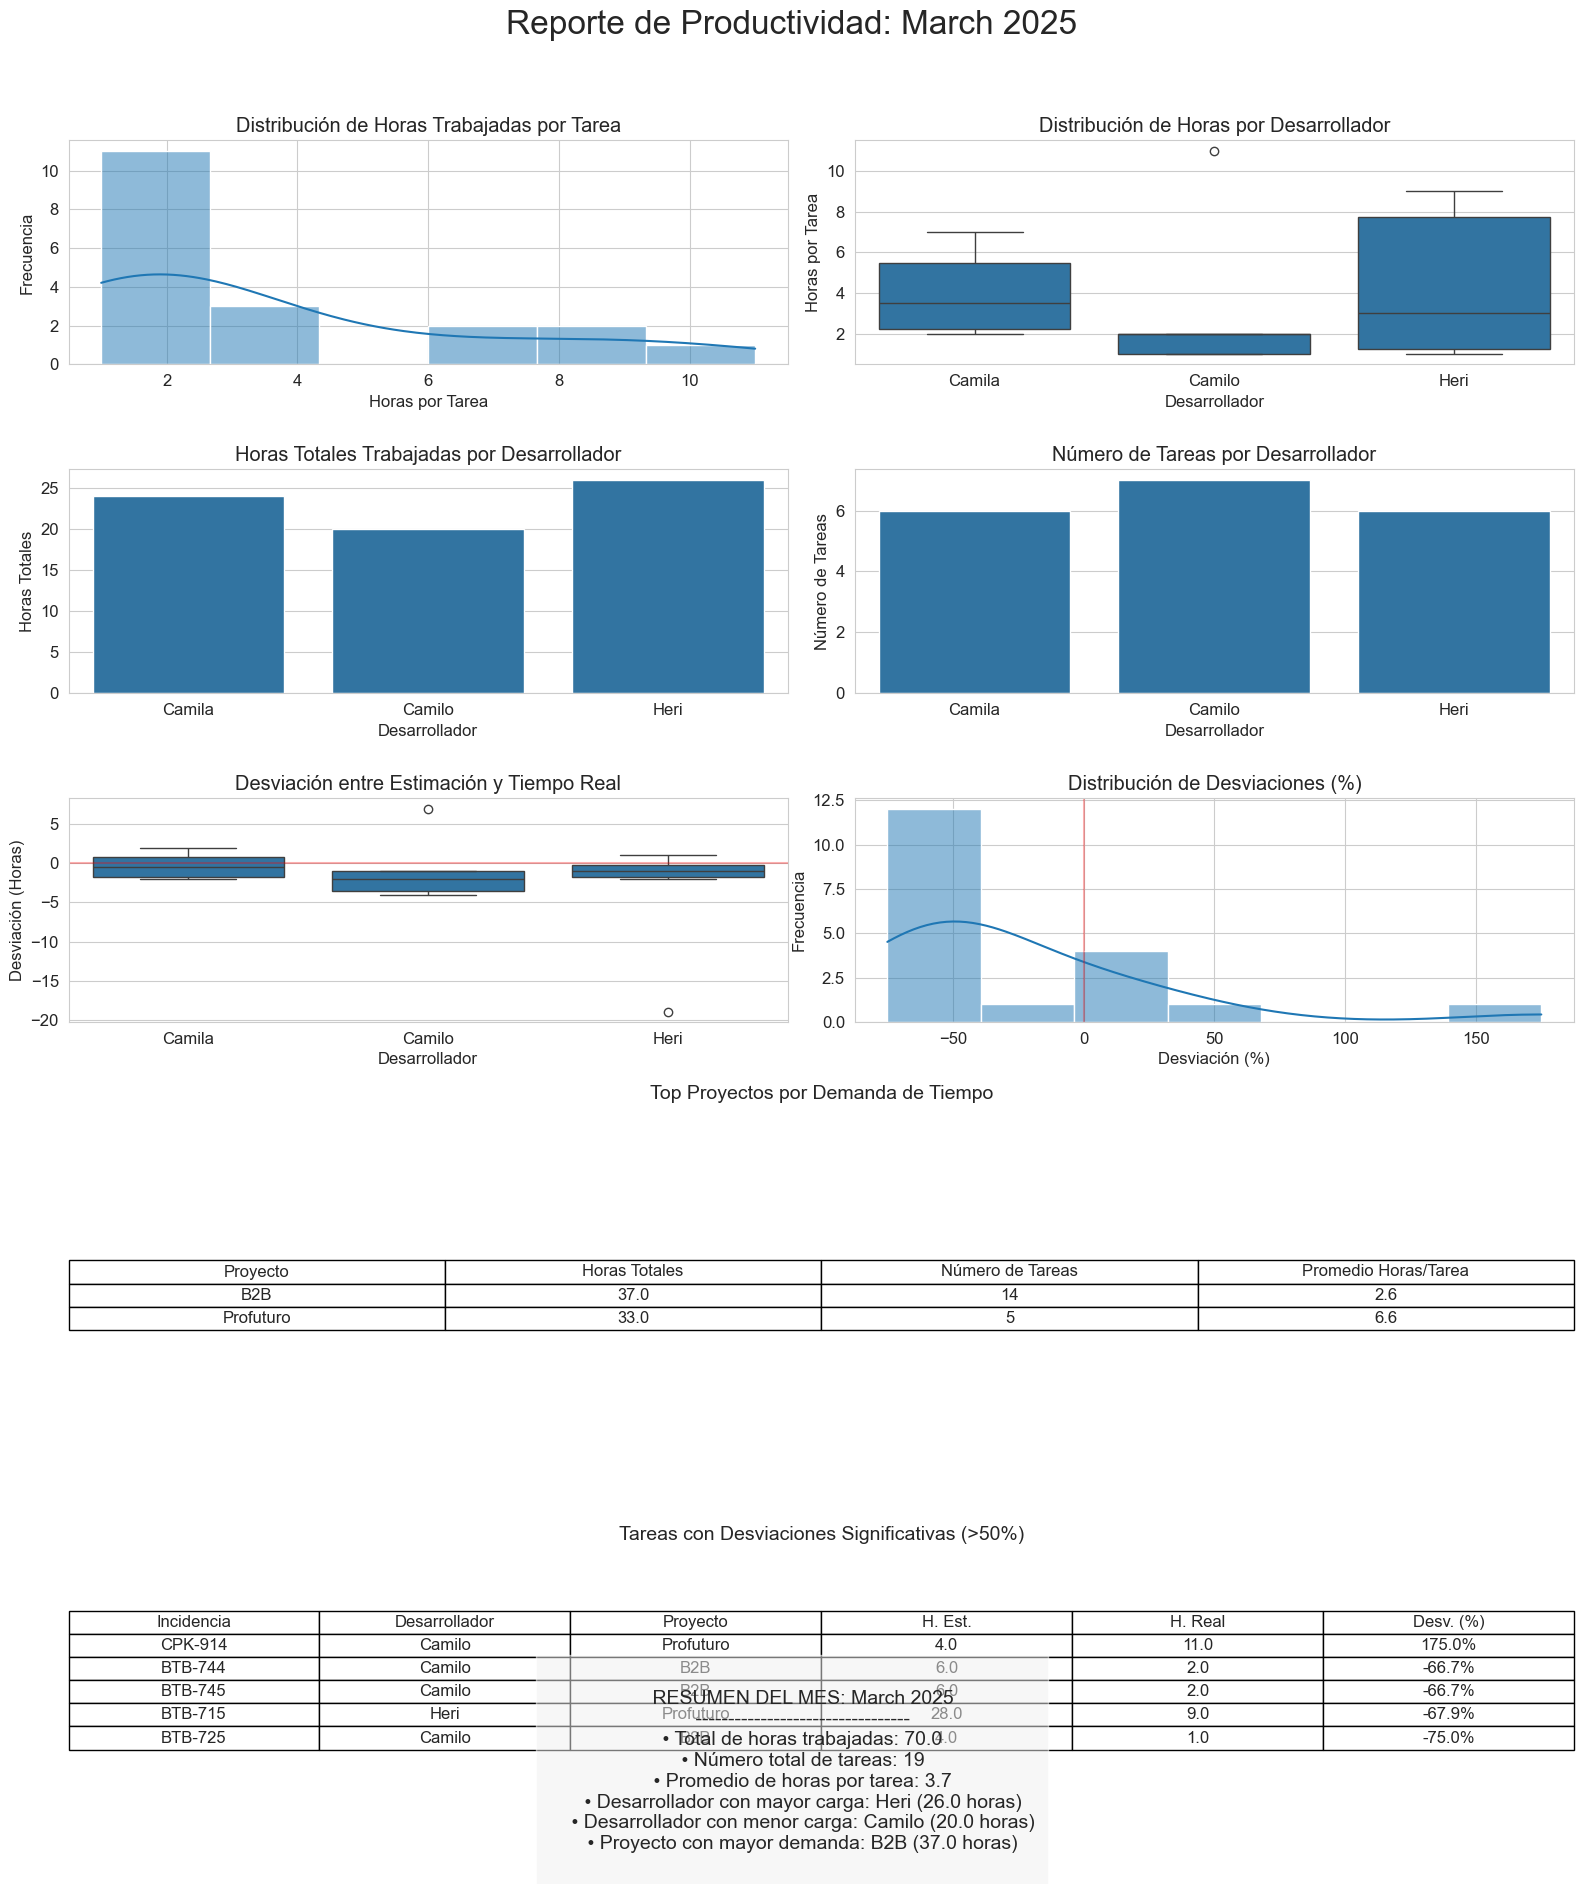


    RESUMEN DEL MES: March 2025
    ---------------------------------
    • Total de horas trabajadas: 70.0
    • Número total de tareas: 19
    • Promedio de horas por tarea: 3.7
    • Desarrollador con mayor carga: Heri (26.0 horas)
    • Desarrollador con menor carga: Camilo (20.0 horas)
    • Proyecto con mayor demanda: B2B (37.0 horas)
    
Generando reporte para el mes: 2025-02


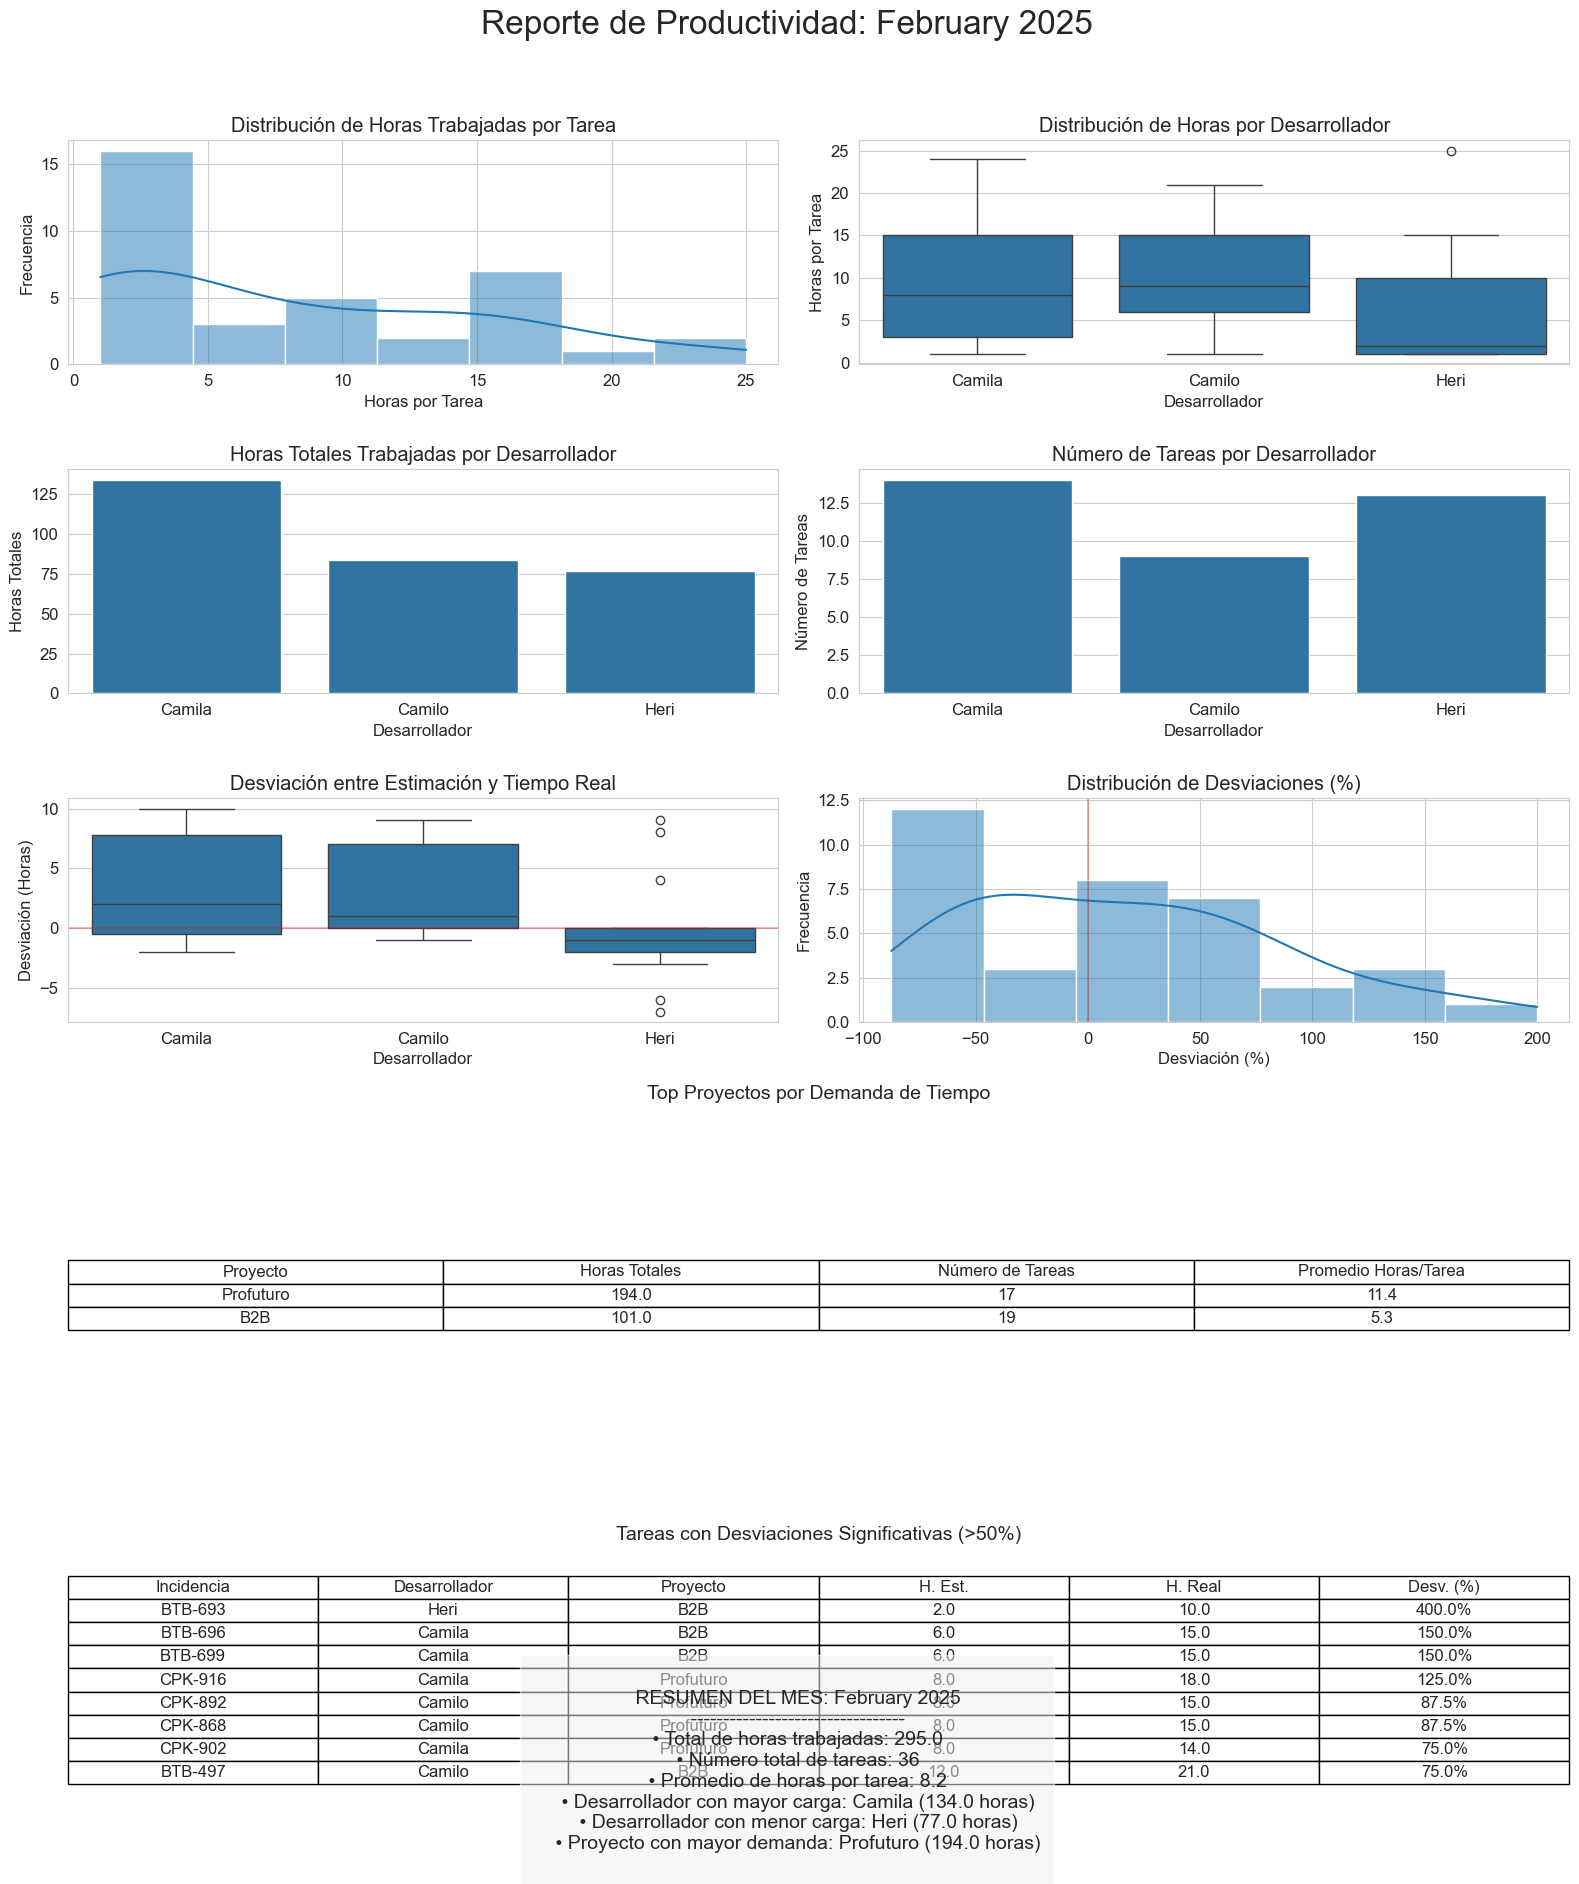


    RESUMEN DEL MES: February 2025
    ---------------------------------
    • Total de horas trabajadas: 295.0
    • Número total de tareas: 36
    • Promedio de horas por tarea: 8.2
    • Desarrollador con mayor carga: Camila (134.0 horas)
    • Desarrollador con menor carga: Heri (77.0 horas)
    • Proyecto con mayor demanda: Profuturo (194.0 horas)
    
Generando reporte para el mes: 2025-01


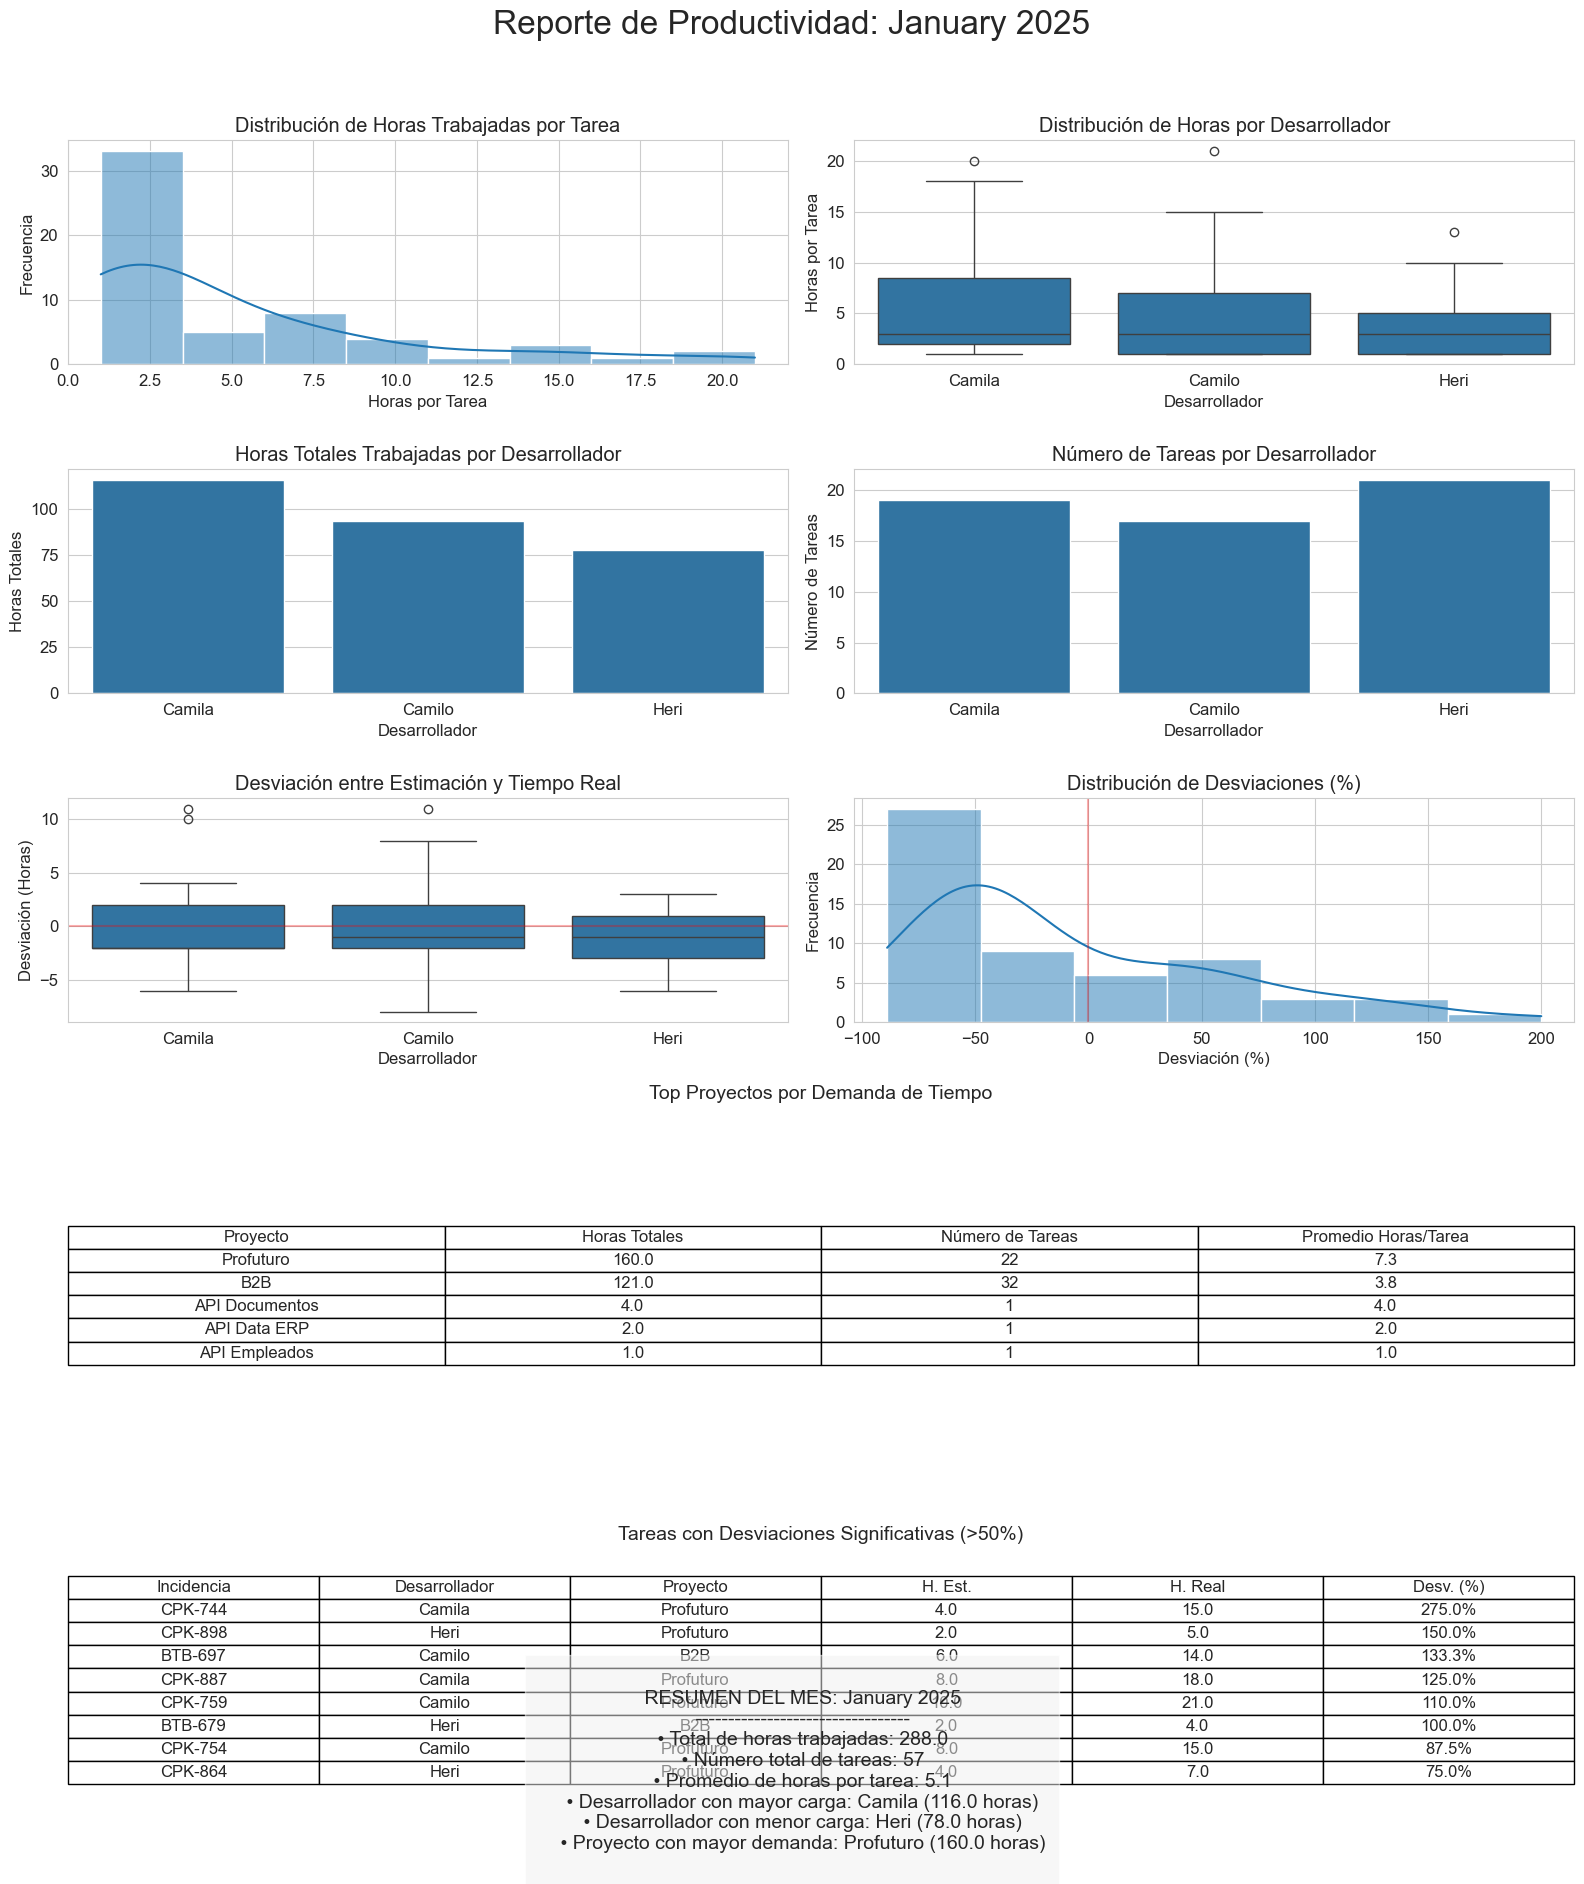


    RESUMEN DEL MES: January 2025
    ---------------------------------
    • Total de horas trabajadas: 288.0
    • Número total de tareas: 57
    • Promedio de horas por tarea: 5.1
    • Desarrollador con mayor carga: Camila (116.0 horas)
    • Desarrollador con menor carga: Heri (78.0 horas)
    • Proyecto con mayor demanda: Profuturo (160.0 horas)
    

RESUMEN DE TODOS LOS REPORTES GENERADOS:
     fecha  total_horas  total_tareas
0  2025-03         70.0            19
1  2025-02        295.0            36
2  2025-01        288.0            57


In [74]:
# Generar reportes mensuales para los últimos 4 meses disponibles
# Obtener la lista ordenada de meses para generar reportes
fechas_unicas = sorted(df_estimaciones["Año_Mes"].dropna().unique(), reverse=True)

# Limitar a los últimos 4 meses disponibles
meses_a_mostrar = fechas_unicas[:3]

# Crear una lista para almacenar los reportes generados
reportes_generados = []

# Generar un reporte para cada mes de los últimos 4
for fecha_mes in meses_a_mostrar:
    print(f"Generando reporte para el mes: {fecha_mes}")
    fig, report_data = generar_reporte_productividad(fecha_mes)

    # Mostrar el reporte
    plt.figure(fig.number)
    plt.show()

    # Guardar información del reporte
    reportes_generados.append(
        {
            "fecha": fecha_mes,
            "titulo": report_data["report_title"],
            "total_horas": report_data["total_hours"],
            "total_tareas": report_data["total_tasks"],
        }
    )

    # Mostrar un resumen del reporte
    print(report_data["summary_text"])
    print("=" * 50)

# Mostrar un resumen de los reportes generados
print("\nRESUMEN DE TODOS LOS REPORTES GENERADOS:")
resumen_df = pd.DataFrame(reportes_generados)
print(resumen_df[["fecha", "total_horas", "total_tareas"]])

##### 4. Horas trabajadas y número de tareas

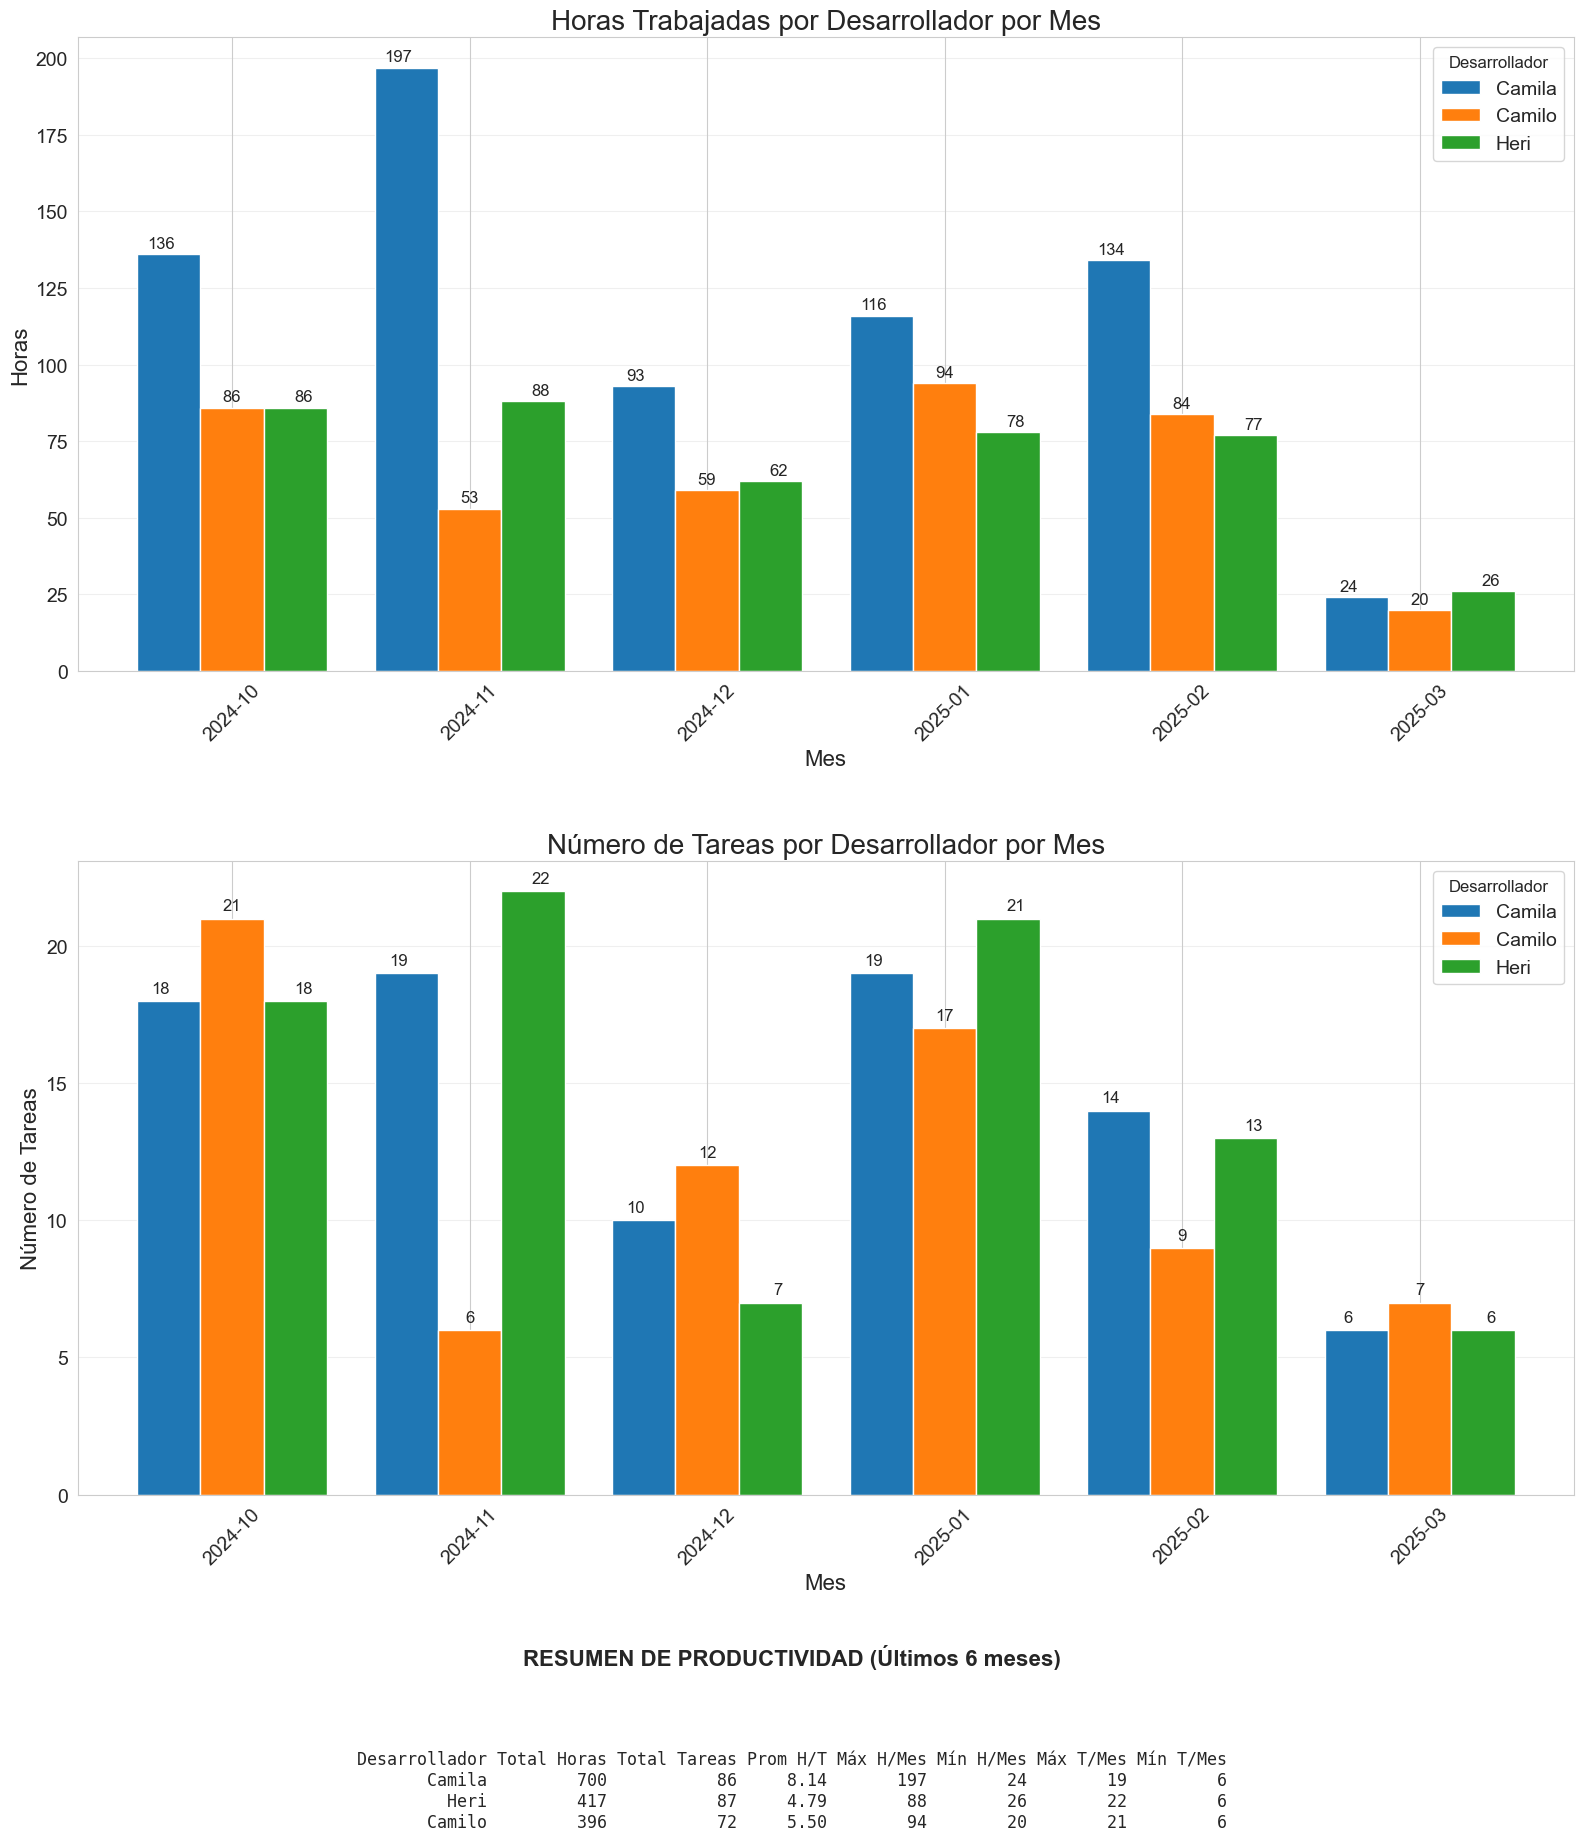

<Figure size 1600x800 with 0 Axes>

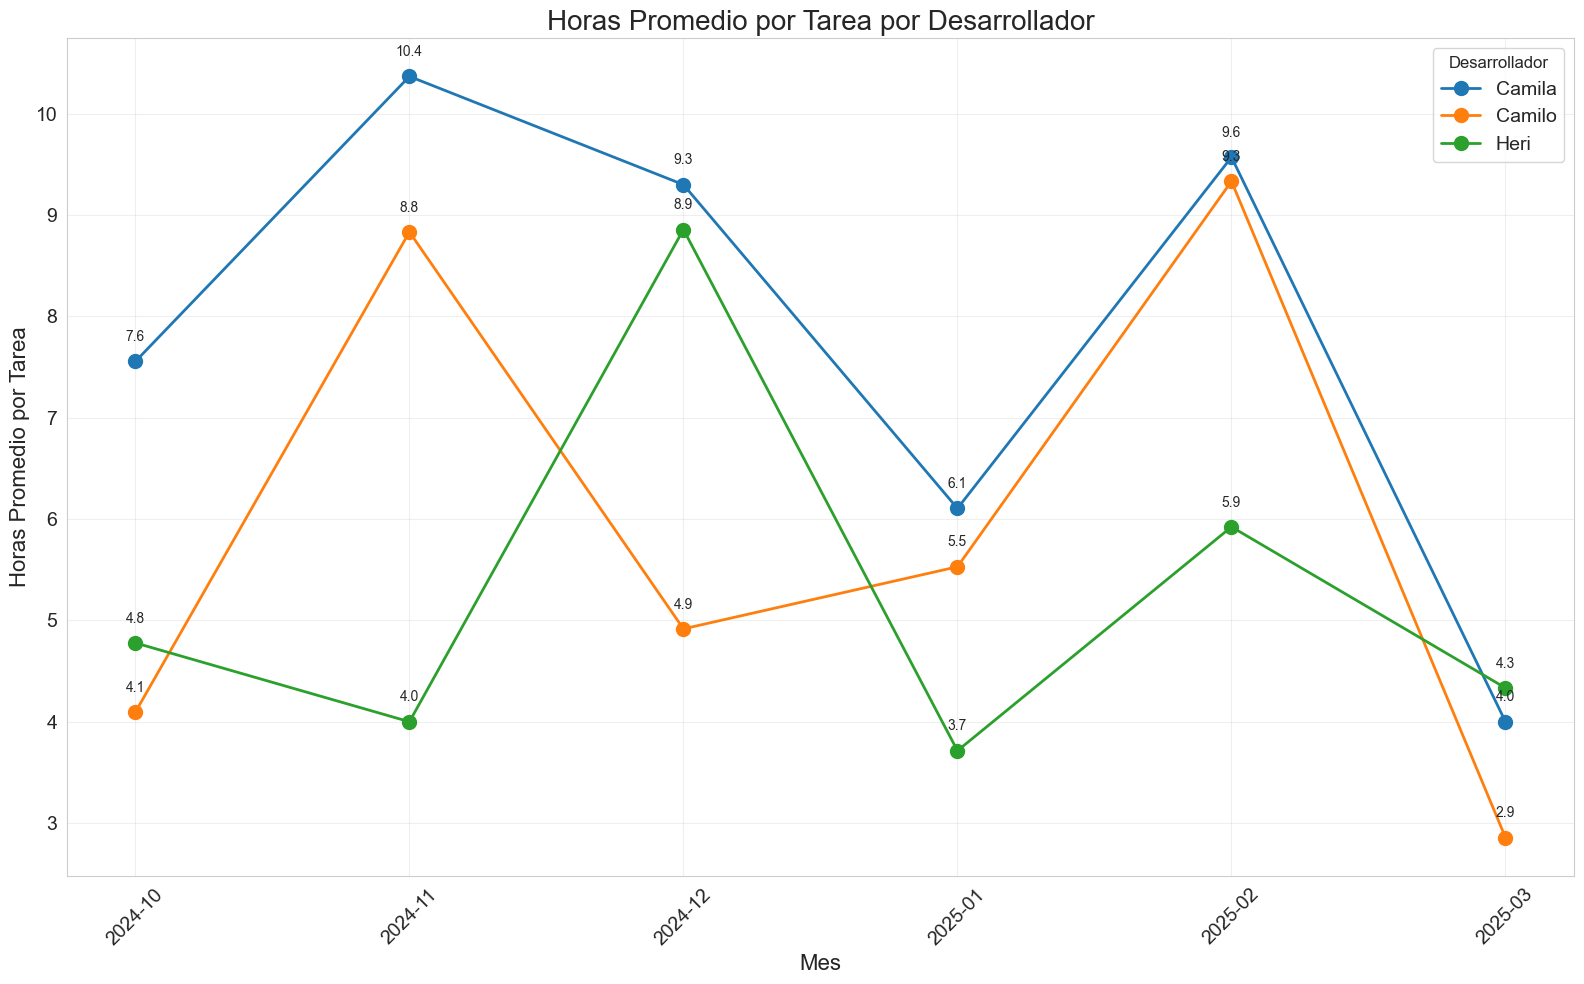

In [75]:
import seaborn as sns
import pandas as pd
# import calendar

import matplotlib.pyplot as plt

# Configurar estilo de visualización
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (16, 10)

# 1. Obtener los últimos 6 meses de datos para el análisis
ultimos_meses = sorted(df_estimaciones["Año_Mes"].dropna().unique())[-6:]

# Filtrar datos para estos meses
df_periodo = df_estimaciones[df_estimaciones["Año_Mes"].isin(ultimos_meses)]

# 2. Reporte de horas trabajadas por desarrollador por mes
fig, ax = plt.subplots(2, 1, figsize=(16, 18))

# Agrupar los datos por mes y desarrollador
horas_por_dev_mes = df_periodo.pivot_table(
    index="Año_Mes", columns="Desarrollador", values="Horas totales", aggfunc="sum"
).fillna(0)

# Ordenar los meses cronológicamente
horas_por_dev_mes = horas_por_dev_mes.reindex(ultimos_meses)

# Crear el gráfico de barras agrupadas
horas_por_dev_mes.plot(kind="bar", ax=ax[0], width=0.8)
ax[0].set_title("Horas Trabajadas por Desarrollador por Mes", fontsize=20)
ax[0].set_ylabel("Horas", fontsize=16)
ax[0].set_xlabel("Mes", fontsize=16)
ax[0].tick_params(axis="y", labelsize=14)
ax[0].tick_params(axis="x", labelsize=14, rotation=45)
ax[0].legend(title="Desarrollador", fontsize=14)
ax[0].grid(True, axis="y", alpha=0.3)

# Añadir texto con los valores sobre cada barra
for i, col in enumerate(horas_por_dev_mes.columns):
    for j, (idx, val) in enumerate(horas_por_dev_mes[col].items()):
        if val > 0:
            ax[0].text(
                j - 0.3 + i * 0.3, val + 2, f"{val:.0f}", ha="center", fontsize=12
            )

# 3. Reporte de número de tareas por desarrollador por mes
tareas_por_dev_mes = df_periodo.pivot_table(
    index="Año_Mes", columns="Desarrollador", values="Incidencia", aggfunc="count"
).fillna(0)

# Ordenar los meses cronológicamente
tareas_por_dev_mes = tareas_por_dev_mes.reindex(ultimos_meses)

# Crear el gráfico de barras apiladas
tareas_por_dev_mes.plot(kind="bar", ax=ax[1], width=0.8)
ax[1].set_title("Número de Tareas por Desarrollador por Mes", fontsize=20)
ax[1].set_ylabel("Número de Tareas", fontsize=16)
ax[1].set_xlabel("Mes", fontsize=16)
ax[1].tick_params(axis="y", labelsize=14)
ax[1].tick_params(axis="x", labelsize=14, rotation=45)
ax[1].legend(title="Desarrollador", fontsize=14)
ax[1].grid(True, axis="y", alpha=0.3)

# Añadir texto con los valores sobre cada barra
for i, col in enumerate(tareas_por_dev_mes.columns):
    for j, (idx, val) in enumerate(tareas_por_dev_mes[col].items()):
        if val > 0:
            ax[1].text(
                j - 0.3 + i * 0.3, val + 0.3, f"{val:.0f}", ha="center", fontsize=12
            )

# 4. Añadir tabla resumen con estadísticas por desarrollador
resumen_stats = pd.DataFrame(
    {
        "Desarrollador": [],
        "Total Horas": [],
        "Total Tareas": [],
        "Promedio Horas/Tarea": [],
        "Máx Horas/Mes": [],
        "Mín Horas/Mes": [],
        "Máx Tareas/Mes": [],
        "Mín Tareas/Mes": [],
    }
)

for dev in df_periodo["Desarrollador"].unique():
    dev_data = df_periodo[df_periodo["Desarrollador"] == dev]
    total_horas = dev_data["Horas totales"].sum()
    total_tareas = len(dev_data)
    promedio_horas = total_horas / total_tareas if total_tareas > 0 else 0

    horas_por_mes = dev_data.groupby("Año_Mes")["Horas totales"].sum()
    tareas_por_mes = dev_data.groupby("Año_Mes")["Incidencia"].count()

    max_horas_mes = horas_por_mes.max() if not horas_por_mes.empty else 0
    min_horas_mes = horas_por_mes.min() if not horas_por_mes.empty else 0
    max_tareas_mes = tareas_por_mes.max() if not tareas_por_mes.empty else 0
    min_tareas_mes = tareas_por_mes.min() if not tareas_por_mes.empty else 0

    resumen_stats = pd.concat(
        [
            resumen_stats,
            pd.DataFrame(
                {
                    "Desarrollador": [dev],
                    "Total Horas": [total_horas],
                    "Total Tareas": [total_tareas],
                    "Promedio Horas/Tarea": [round(promedio_horas, 2)],
                    "Máx Horas/Mes": [max_horas_mes],
                    "Mín Horas/Mes": [min_horas_mes],
                    "Máx Tareas/Mes": [max_tareas_mes],
                    "Mín Tareas/Mes": [min_tareas_mes],
                }
            ),
        ],
        ignore_index=True,
    )

# Ordenar por total de horas
resumen_stats = resumen_stats.sort_values("Total Horas", ascending=False)

# Añadir tabla de resumen al pie del gráfico
plt.figtext(
    0.5,
    0.02,
    f"RESUMEN DE PRODUCTIVIDAD (Últimos {len(ultimos_meses)} meses)",
    ha="center",
    fontweight="bold",
    fontsize=16,
)

table_data = []
for _, row in resumen_stats.iterrows():
    table_data.append(
        [
            row["Desarrollador"],
            f"{row['Total Horas']:.0f}",
            f"{row['Total Tareas']:.0f}",
            f"{row['Promedio Horas/Tarea']:.2f}",
            f"{row['Máx Horas/Mes']:.0f}",
            f"{row['Mín Horas/Mes']:.0f}",
            f"{row['Máx Tareas/Mes']:.0f}",
            f"{row['Mín Tareas/Mes']:.0f}",
        ]
    )

plt.figtext(
    0.5,
    -0.07,
    pd.DataFrame(
        table_data,
        columns=[
            "Desarrollador",
            "Total Horas",
            "Total Tareas",
            "Prom H/T",
            "Máx H/Mes",
            "Mín H/Mes",
            "Máx T/Mes",
            "Mín T/Mes",
        ],
    ).to_string(index=False),
    ha="center",
    fontsize=12,
    fontfamily="monospace",
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.subplots_adjust(hspace=0.3)

# Mostrar el gráfico
plt.show()

# 5. Gráfico adicional: Horas promedio por tarea y desarrollador por mes
plt.figure(figsize=(16, 8))
horas_promedio = (
    df_periodo.pivot_table(
        index="Año_Mes", columns="Desarrollador", values="Horas totales", aggfunc="mean"
    )
    .fillna(0)
    .reindex(ultimos_meses)
)

horas_promedio.plot(kind="line", marker="o", markersize=10, linewidth=2)
plt.title("Horas Promedio por Tarea por Desarrollador", fontsize=20)
plt.ylabel("Horas Promedio por Tarea", fontsize=16)
plt.xlabel("Mes", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(title="Desarrollador", fontsize=14)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

# Añadir valores en los puntos del gráfico
for col in horas_promedio.columns:
    for i, (idx, val) in enumerate(horas_promedio[col].items()):
        if val > 0:
            plt.text(i, val + 0.2, f"{val:.1f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()

#### 5. asds

C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_38268\2932339972.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_38268\2932339972.py:95: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
c:\laragon\www\jupiter\bitbucket\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


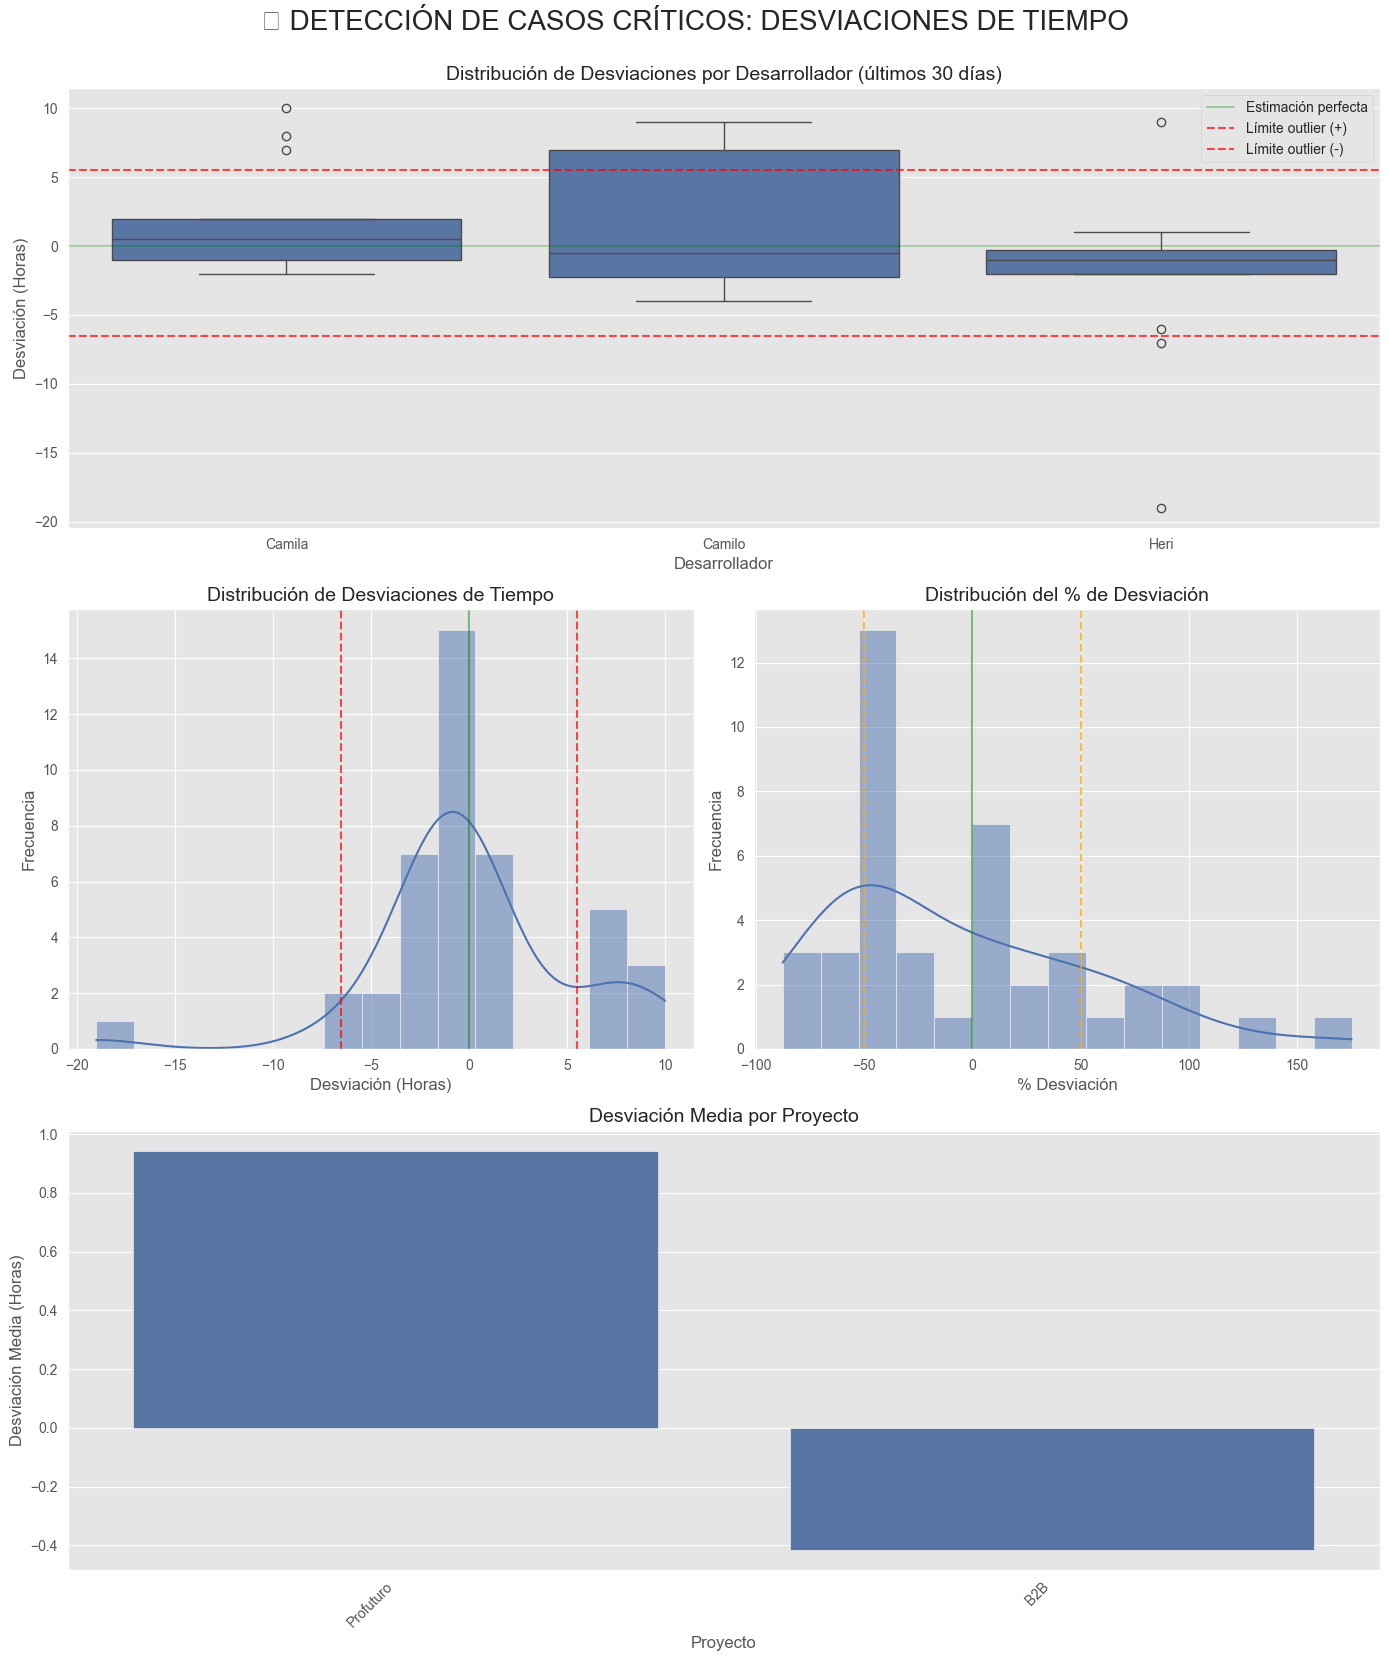



🚨 CASOS CRÍTICOS: MAYORES DESVIACIONES DE TIEMPO

Incidencia  Proyecto Desarrollador  H. Est.  H. Real  Desv. (h) % Desv.
   CPK-916 Profuturo        Camila      8.0     18.0       10.0    125%
   BTB-497       B2B        Camilo     12.0     21.0        9.0     75%
   CPK-757 Profuturo          Heri     16.0     25.0        9.0     56%
   CPK-917 Profuturo        Camila     16.0     24.0        8.0     50%
   CPK-906 Profuturo        Camila     10.0     17.0        7.0     70%
   CPK-914 Profuturo        Camilo      4.0     11.0        7.0    175%
   CPK-868 Profuturo        Camilo      8.0     15.0        7.0     88%
   CPK-892 Profuturo        Camilo      8.0     15.0        7.0     88%
   BTB-725       B2B        Camilo      4.0      1.0       -3.0    -75%
   BTB-744       B2B        Camilo      6.0      2.0       -4.0    -67%
   BTB-745       B2B        Camilo      6.0      2.0       -4.0    -67%
   CPK-920 Profuturo          Heri      8.0      2.0       -6.0    -75%
   CPK-920 P

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

# Configurar estilo de visualización
plt.style.use("ggplot")
sns.set_palette("deep")
plt.rcParams["figure.figsize"] = (14, 12)

# 1. DETECCIÓN DE OUTLIERS Y CASOS CRÍTICOS

# Filtrar datos del último mes para el análisis
hoy = datetime.now()
fecha_limite = hoy - timedelta(days=30)
df_ultimo_mes = df_estimaciones[df_estimaciones["Fecha inicio"] >= fecha_limite].copy()

# Calcular estadísticas descriptivas de la desviación
stats_desviacion = df_ultimo_mes["Desviacion"].describe()

# Calcular el rango intercuartil (IQR) para detectar outliers
Q1 = df_ultimo_mes["Desviacion"].quantile(0.25)
Q3 = df_ultimo_mes["Desviacion"].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para outliers (1.5 * IQR es el estándar)
limite_superior = Q3 + 1.5 * IQR
limite_inferior = Q1 - 1.5 * IQR

# Identificar outliers positivos (subestimaciones graves)
outliers_positivos = df_ultimo_mes[df_ultimo_mes["Desviacion"] > limite_superior]
outliers_negativos = df_ultimo_mes[df_ultimo_mes["Desviacion"] < limite_inferior]

# Calcular porcentaje de desviación para cada tarea
df_ultimo_mes["Porcentaje_Desviacion"] = (
    df_ultimo_mes["Desviacion"] / df_ultimo_mes["Horas estimadas"] * 100
)

# Crear una figura con 4 subplots
fig = plt.figure(figsize=(14, 18))
fig.suptitle(
    "🚨 DETECCIÓN DE CASOS CRÍTICOS: DESVIACIONES DE TIEMPO", fontsize=20, y=0.95
)

# 1. Boxplot de desviaciones
ax1 = fig.add_subplot(3, 1, 1)
sns.boxplot(x="Desarrollador", y="Desviacion", data=df_ultimo_mes, ax=ax1)
ax1.set_title(
    "Distribución de Desviaciones por Desarrollador (últimos 30 días)", fontsize=14
)
ax1.set_ylabel("Desviación (Horas)", fontsize=12)
ax1.axhline(y=0, color="green", linestyle="-", alpha=0.3, label="Estimación perfecta")
ax1.axhline(
    y=limite_superior,
    color="red",
    linestyle="--",
    alpha=0.7,
    label=f"Límite outlier (+)",
)
ax1.axhline(
    y=limite_inferior,
    color="red",
    linestyle="--",
    alpha=0.7,
    label=f"Límite outlier (-)",
)
ax1.legend()

# 2. Histograma de todas las desviaciones
ax2 = fig.add_subplot(3, 2, 3)
sns.histplot(df_ultimo_mes["Desviacion"], kde=True, ax=ax2, bins=15)
ax2.axvline(x=0, color="green", linestyle="-", alpha=0.5)
ax2.axvline(x=limite_superior, color="red", linestyle="--", alpha=0.7)
ax2.axvline(x=limite_inferior, color="red", linestyle="--", alpha=0.7)
ax2.set_title("Distribución de Desviaciones de Tiempo", fontsize=14)
ax2.set_xlabel("Desviación (Horas)", fontsize=12)
ax2.set_ylabel("Frecuencia", fontsize=12)

# 3. Histograma de porcentaje de desviaciones
ax3 = fig.add_subplot(3, 2, 4)
sns.histplot(
    df_ultimo_mes["Porcentaje_Desviacion"].clip(-200, 200), kde=True, ax=ax3, bins=15
)
ax3.axvline(x=0, color="green", linestyle="-", alpha=0.5)
ax3.axvline(x=50, color="orange", linestyle="--", alpha=0.7)
ax3.axvline(x=-50, color="orange", linestyle="--", alpha=0.7)
ax3.set_title("Distribución del % de Desviación", fontsize=14)
ax3.set_xlabel("% Desviación", fontsize=12)
ax3.set_ylabel("Frecuencia", fontsize=12)

# 4. Barplot de desviación media por proyecto
ax4 = fig.add_subplot(3, 1, 3)
proyectos_desviacion = df_ultimo_mes.groupby("Proyecto")["Desviacion"].agg(
    ["mean", "count", "std"]
)
proyectos_desviacion = proyectos_desviacion[
    proyectos_desviacion["count"] >= 2
]  # Al menos 2 tareas
proyectos_desviacion = proyectos_desviacion.sort_values("mean", ascending=False)

sns.barplot(x=proyectos_desviacion.index, y=proyectos_desviacion["mean"], ax=ax4)
ax4.set_title("Desviación Media por Proyecto", fontsize=14)
ax4.set_ylabel("Desviación Media (Horas)", fontsize=12)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha="right")

# Añadir el número de tareas por proyecto como etiquetas
for i, p in enumerate(proyectos_desviacion.index):
    count = proyectos_desviacion.loc[p, "count"]
    mean = proyectos_desviacion.loc[p, "mean"]
    ax4.annotate(
        f"n={count}\n{mean:.1f}h",
        (i, mean + (0.5 if mean >= 0 else -1.5)),
        ha="center",
        va="center",
        fontsize=9,
    )

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Crear tabla de casos críticos (ordenados por desviación absoluta)
print("\n\n🚨 CASOS CRÍTICOS: MAYORES DESVIACIONES DE TIEMPO")
print("=====================================================\n")

# Filtrar casos con desviación significativa (más del 50% o al menos 4 horas)
casos_criticos = df_ultimo_mes[
    (abs(df_ultimo_mes["Porcentaje_Desviacion"]) > 50)
    | (abs(df_ultimo_mes["Desviacion"]) >= 4)
].sort_values("Desviacion", ascending=False)

# Mostrar las columnas relevantes
columnas_mostrar = [
    "Incidencia",
    "Proyecto",
    "Desarrollador",
    "Horas estimadas",
    "Horas totales",
    "Desviacion",
    "Porcentaje_Desviacion",
]

# Limitar a los 15 casos más críticos
tabla_casos = casos_criticos[columnas_mostrar].head(15).copy()
tabla_casos.columns = [
    "Incidencia",
    "Proyecto",
    "Desarrollador",
    "H. Est.",
    "H. Real",
    "Desv. (h)",
    "% Desv.",
]
tabla_casos["% Desv."] = tabla_casos["% Desv."].round(0).astype(int).astype(str) + "%"

print(tabla_casos.to_string(index=False))

# Estadísticas generales
print("\n\n📊 ESTADÍSTICAS DE DESVIACIÓN (ÚLTIMOS 30 DÍAS)")
print("=====================================================")
print(f"Total tareas analizadas: {len(df_ultimo_mes)}")
print(f"Desviación media: {df_ultimo_mes['Desviacion'].mean():.2f} horas")
print(f"Desviación mediana: {df_ultimo_mes['Desviacion'].median():.2f} horas")
print(f"Rango intercuartil: {IQR:.2f} horas")
print(f"Límite superior outliers: {limite_superior:.2f} horas")
print(f"Límite inferior outliers: {limite_inferior:.2f} horas")
print(
    f"Casos con desviación positiva: {(df_ultimo_mes['Desviacion'] > 0).sum()} ({(df_ultimo_mes['Desviacion'] > 0).mean() * 100:.1f}%)"
)
print(
    f"Casos con desviación negativa: {(df_ultimo_mes['Desviacion'] < 0).sum()} ({(df_ultimo_mes['Desviacion'] < 0).mean() * 100:.1f}%)"
)
print(
    f"Casos con estimación perfecta: {(df_ultimo_mes['Desviacion'] == 0).sum()} ({(df_ultimo_mes['Desviacion'] == 0).mean() * 100:.1f}%)"
)

# Análisis por desarrollador
print("\n\n👨‍💻 ANÁLISIS POR DESARROLLADOR")
print("=====================================================")
dev_stats = (
    df_ultimo_mes.groupby("Desarrollador")
    .agg(
        Tareas=("Incidencia", "count"),
        Media_Desviacion=("Desviacion", "mean"),
        Mediana_Desviacion=("Desviacion", "median"),
        Desviacion_Max=("Desviacion", "max"),
        Desviacion_Min=("Desviacion", "min"),
        Pct_Subestimacion=("Desviacion", lambda x: (x > 0).mean() * 100),
        Pct_Sobreestimacion=("Desviacion", lambda x: (x < 0).mean() * 100),
        Pct_Exacto=("Desviacion", lambda x: (x == 0).mean() * 100),
    )
    .sort_values("Pct_Subestimacion", ascending=False)
)

print(dev_stats.round(2))